## BraTS like registration toolkit built upon HD-BET and ANTsPY

- Re-orientation to LPS/RAI
- Image registration to SRI-24 Atlas  which includes the following steps
- N4 Bias correction (This is a TEMPORARY STEP, and is not applied in the final co-registered output images. It is only use to facilitate optimal registration.)
- Rigid Registration of T1, T2, FLAIR to T1CE
- Rigid Registration of T1CE to SRI-24 atlas 
- Applying transformation to the reoriented images

Inspiration from https://github.com/neuronflow/BraTS-Toolkit

In [1]:
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


import shutil
import tempfile
import sys
import math
import pandas as pd
import subprocess
import pdb
import nibabel as nib
import ants
import copy
from subprocess import Popen
from subprocess import PIPE
import multiprocessing as mp
from datetime import datetime
from uuid import uuid4

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    NormalizeIntensityd,
    ResizeWithPadOrCropd,
    SpatialPadd,
    Orientationd,
    ScaleIntensityd,
    ScaleIntensityRanged,
    ScaleIntensity,
    ScaleIntensityRange,
    ScaleIntensityRangePercentilesd,
    Spacingd,
)
from monai.utils import set_determinism
from ignite.metrics import Accuracy


import glob
import monai
import scipy
from scipy import ndimage


from collections import OrderedDict
from typing import Callable, Sequence, Type, Union

#from monai.visualize import GradCAM
import matplotlib.pyplot as plt
# import itkwidgets
# from itkwidgets import view
from tqdm import tqdm
import random
monai.config.print_config()

MONAI version: 0.9.0
Numpy version: 1.22.3
Pytorch version: 1.10.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/mmiv-ml/anaconda3/envs/sa_tumorseg22/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-rec

In [3]:
seedvalue=4294967295
set_determinism(seed=seedvalue)

In [4]:
!pwd

/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22


## Loading dataframe, a portion of TCGA-LGG-GBM set which are not preprocessed by BraTS organizer

In [5]:
pd.set_option('display.max_colwidth', None)
data_rpath = '/raid/brats2021/LGG_1p19q_rawNifti'
preprocdata_folder = os.path.join(data_rpath,'LGG_1p19q_rawNifti_renamed')
preprocdata_folder

'/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed'

In [6]:
images20t1 = list()
images20t1ce = list()
images20t2 = list()
images20flair = list()


SubIDList = list()
t1cwList = glob.glob(os.path.join(preprocdata_folder, 'LGG-*/LGG-*_t1Gd.nii.gz'))


for at1cwPath in t1cwList:
    aSubID = os.path.basename(os.path.dirname(at1cwPath))
    SubIDList.append(aSubID)
    images20t1ce.append(at1cwPath)
    #pdb.set_trace()
    images20t2.append(glob.glob(f"{preprocdata_folder}/{aSubID}/{aSubID}_*t2.nii.gz*")[0])
    

    
    

In [7]:
TCGAProcSubjectsDF = pd.DataFrame.from_dict({'SubjectID':SubIDList, 't1cwPath':images20t1ce, 't2wPath':images20t2})
TCGAProcSubjectsDF = TCGAProcSubjectsDF.sort_values(by = ['SubjectID'], ignore_index = True)
TCGAProcSubjectsDF

SubjectID  \
0     LGG-104   
1     LGG-203   
2     LGG-210   
3     LGG-216   
4     LGG-218   
..        ...   
154   LGG-651   
155   LGG-658   
156   LGG-659   
157   LGG-660   
158   LGG-766   

                                                                                      t1cwPath  \
0    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-104/LGG-104_t1Gd.nii.gz   
1    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-203/LGG-203_t1Gd.nii.gz   
2    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-210/LGG-210_t1Gd.nii.gz   
3    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-216/LGG-216_t1Gd.nii.gz   
4    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-218/LGG-218_t1Gd.nii.gz   
..                                                                                         ...   
154  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-651/LGG-651_t1Gd.nii.gz   
155  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-658/LGG-658_t1Gd.nii.gz   
156  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-659/LGG-659_t1Gd.nii.gz   
157  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-660/LGG-660_t1Gd.nii.gz   
158  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-766/LGG-766_t1Gd.nii.gz   

                                                                                     t2wPath  
0    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-104/LGG-104_t2.nii.gz  
1    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-203/LGG-203_t2.nii.gz  
2    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-210/LGG-210_t2.nii.gz  
3    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-216/LGG-216_t2.nii.gz  
4    /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-218/LGG-218_t2.nii.gz  
..                                                                                       ...  
154  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-651/LGG-651_t2.nii.gz  
155  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-658/LGG-658_t2.nii.gz  
156  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-659/LGG-659_t2.nii.gz  
157  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-660/LGG-660_t2.nii.gz  
158  /raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-766/LGG-766_t2.nii.gz  

[159 rows x 3 columns]

In [8]:
subject_corruptlist = ['LGG-563', 'LGG-601', 'LGG-609', 'LGG-610', 'LGG-612', 'LGG-613','LGG-624', 'LGG-648', 'LGG-651', 'LGG-579', 'LGG-601', 'LGG-601', 'LGG-612', 'LGG-613', 'LGG-624',\
                       'LGG-648', 'LGG-651', 'LGG-545', 'LGG-572','LGG-563', 'LGG-537', 'LGG-558','LGG-566', 'LGG-570']


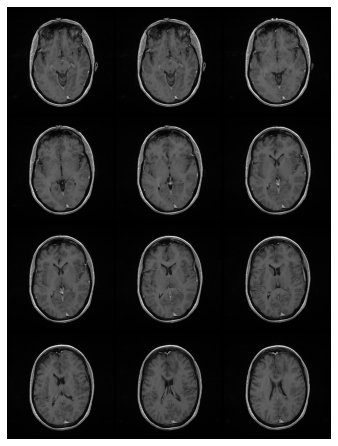

In [9]:
ants.plot(ants.image_read(TCGAProcSubjectsDF.loc[0, 't1cwPath'], reorient="LPS"), axis = 2)

In [10]:
def get_ImageBasicInfo(t1wSRIPath):
    checkSRIT1 = nib.load(t1wSRIPath)
    print(f' atlas shape: {checkSRIT1.shape}, atlas header.get_zooms(): {checkSRIT1.header.get_zooms()}, orientation: {nib.orientations.aff2axcodes(checkSRIT1.affine)},\
    affine\n: {checkSRIT1.affine}')


In [11]:
get_ImageBasicInfo(TCGAProcSubjectsDF.loc[0, 't1cwPath'])

 atlas shape: (256, 256, 60), atlas header.get_zooms(): (0.9375, 0.9375, 3.0), orientation: ('R', 'A', 'S'),    affine
: [[   0.9375        0.            0.         -121.72650146]
 [   0.            0.9375        0.          -97.46150208]
 [   0.            0.            3.          -55.57569885]
 [   0.            0.            0.            1.        ]]


### BraTS like registraion

In [12]:
#### HD-BET installed or not
!hd-bet -h


########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

usage: hd-bet [-h] -i INPUT [-o OUTPUT] [-mode MODE] [-device DEVICE]
              [-tta TTA] [-pp PP] [-s SAVE_MASK]
              [--overwrite_existing OVERWRITE_EXISTING]

optional arguments:
  -h, --help            show this help message and exit
  -i INPUT, --input INPUT
                        input. Can be either a single file name or an input
                        folder. If file: must be nifti (.nii.gz) and can only
                        be 3D. No support for 4d images, use fslsplit to split
                        4d sequences into 3d images. If folder: all files
                        endin

In [13]:
ants.registration

<function ants.registration.interface.registration(fixed, moving, type_of_transform='SyN', initial_transform=None, outprefix='', mask=None, grad_step=0.2, flow_sigma=3, total_sigma=0, aff_metric='mattes', aff_sampling=32, aff_random_sampling_rate=0.2, syn_metric='mattes', syn_sampling=32, reg_iterations=(40, 20, 0), aff_iterations=(2100, 1200, 1200, 10), aff_shrink_factors=(6, 4, 2, 1), aff_smoothing_sigmas=(3, 2, 1, 0), write_composite_transform=False, random_seed=None, verbose=False, multivariate_extras=None, restrict_transformation=None, **kwargs)>

### Running hd-bet on mni or fslreorient2std space

In [14]:
def brats_ants_mni152bet_2channelsregistration(aSubjectDct, AtlasPath:str, AtlasMaskPath:str, save_dir:str):

    
    atlas_brain_sri24_bet = ants.image_read(AtlasPath) ## already in reorient = 'RAI'
    atlas_brain_sri24_betMask =  ants.image_read(AtlasMaskPath) ##already in reorient = 'RAI'
    #T1_sri244Apply = os.path.join(srdir, 'T1_rereorient.nii.gz')
    #save_dir = '/data-10tb/saruarlive/dataProject/BratsData/MICCAI_BraTS2020_T1contrastPlusBrainMask'
    
    aSubId = aSubjectDct['SubjectID']
    print(f"Start processing {aSubId}\n\n")
    aSubDir = os.path.join(save_dir, aSubId)
    if not os.path.exists(aSubDir):
        os.makedirs(aSubDir)
    
    
    neighb_struct = np.ones((3,3,3))

    #print(aSubjectDct)
    
    '''Reorienting and skull stripping'''
    
    
    fslornT1ce = subprocess.run(['fslreorient2std', aSubjectDct['t1cwPath'], f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz'], capture_output=True, text=True)
    T1ceImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', reorient="RAI")
    #ants.image_write(T1ceImg, f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', ri = True)
    

    fslornT2 = subprocess.run(['fslreorient2std', aSubjectDct['t2wPath'], f'{aSubDir}/{aSubId}_t2_reorient.nii.gz'], capture_output=True, text=True)
    T2Img = ants.image_read(f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', reorient="RAI")
    #ants.image_write(T2Img, f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', ri = True)
    
    
    ''' Saving and skull stripping '''
    
    proc_status_t1Gdbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
    proc_status_t2cbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t2_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
    
    
    '''Running registration process'''
    
    T1ceImg_ornbet = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', reorient="RAI")
    T1ceMaskImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient_bet_mask.nii.gz', reorient="RAI")
    T1ceImg_n4 = ants.n4_bias_field_correction(T1ceImg_ornbet, mask = T1ceMaskImg)
    T1ceImg_n4 = T1ceImg_n4*T1ceMaskImg
    

    
    T2Img_ornbet= ants.image_read(f'{aSubDir}/{aSubId}_t2_reorient_bet.nii.gz', reorient="RAI")
    T2MaskImg = ants.image_read(f'{aSubDir}/{aSubId}_t2_reorient_bet_mask.nii.gz', reorient="RAI")
    T2Img_n4 = ants.n4_bias_field_correction(T2Img_ornbet, mask = T2MaskImg)
    T2Img_n4 = T2Img_n4*T2MaskImg
    
        
    '''Setting directory where temporary files will be saved'''
    
    SubOutDir = datetime.now().strftime('%Y%m-%d%H-%M%S-') + str(uuid4())
    outputDirectory = os.path.join(aSubDir,f"TempsOutputWithMaskANTsPy_BraTS21_{SubOutDir}")
    if not os.path.exists(outputDirectory):
        os.mkdir(outputDirectory)
        
        os.mkdir(f"{outputDirectory}/t2_2t1Gd")
        os.mkdir(f"{outputDirectory}/t1Gd_2sri24")
                                   
    
    
    '''T1, T2, and flair to t1ce'''
    
    
    mytx_t2_2t1Gd = ants.registration(fixed=T1ceImg_n4, moving=T2Img_n4, mask = T1ceMaskImg, type_of_transform='Rigid',\
                     verbose = True, outprefix = f"{outputDirectory}/t2_2t1Gd/t2_2t1Gd") ##'SyN' 'TRSAA', 'SyNRA'
    print(mytx_t2_2t1Gd)
    

    '''Registration'''
    
    mytx_t1Gd_2sri24 = ants.registration(fixed=atlas_brain_sri24_bet, moving=T1ceImg_n4, mask = atlas_brain_sri24_betMask, type_of_transform='Rigid',\
                             verbose = True, outprefix = f"{outputDirectory}/t1Gd_2sri24/t1Gd_2sri24") ##'SyN' 'TRSAA', 'SyNRA'
    
    
    
    '''Applying registration and saving'''

    '''T1Gd to sri24'''
    #masked once only
    #T1ceImg = T1ceImg*T1ceMaskImg
    applyRegdT1Gd = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=T1ceImg, transformlist=mytx_t1Gd_2sri24['fwdtransforms'], interpolator='linear')
    
    ants.image_write(applyRegdT1Gd*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t1Gd.nii.gz', ri = True)
    t1GdFinalMask = applyRegdT1Gd.clone()*atlas_brain_sri24_betMask.clone()
    #b_min=T1ceImg.numpy().min(), b_max=T1ceImg.numpy().max()
    
    #applyRegdT1GdArrayScaled = ScaleIntensityRange(applyRegdT1Gd.numpy().min(), applyRegdT1Gd.numpy().max(), b_min=0.0, b_max=1024.0, clip=False)(applyRegdT1Gd.numpy())
    #applyRegdT1GdScaled = applyRegdT1Gd.new_image_like(applyRegdT1GdArrayScaled)
    #ants.image_write(applyRegdT1GdScaled*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t1Gd.nii.gz', ri = True)
    #t1GdFinalMask = applyRegdT1GdScaled.clone()*atlas_brain_sri24_betMask.clone()
    
    t1GdFinalMask = t1GdFinalMask.new_image_like(ndimage.binary_fill_holes(np.where(t1GdFinalMask.numpy()>0, 1., 0.), structure = neighb_struct).astype(np.float32))
    ants.image_write(t1GdFinalMask, f'{aSubDir}/{aSubId}_t1GdBrainROI.nii.gz', ri = True)
    
    
    '''T1, T2, flair to T1GD and then t1gd-sri24'''
    
    
    '''for t2'''
    applyRegdT2 = ants.apply_transforms(fixed=T1ceImg_n4, moving=T2Img, transformlist=mytx_t2_2t1Gd['fwdtransforms'], interpolator='linear')
    applyRegdT2 = applyRegdT2*T1ceMaskImg
    applyRegdT2_sri24 = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=applyRegdT2, transformlist=mytx_t1Gd_2sri24['fwdtransforms'], interpolator='linear')
    ants.image_write(applyRegdT2_sri24*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    #applyRegdT2_sri24 = applyRegdT2_sri24*atlas_brain_sri24_betMask
    #b_min=T2Img.numpy().min(), b_max=T2Img.numpy().max()
    
    #applyRegdT2_sri24ArrayScaled = ScaleIntensityRange(applyRegdT2_sri24.numpy().min(), applyRegdT2_sri24.numpy().max(), b_min=0.0, b_max=1024.0, clip=False)(applyRegdT2_sri24.numpy())
    #applyRegdT2_sri24Scaled = applyRegdT2_sri24.new_image_like(applyRegdT2_sri24ArrayScaled)
    #ants.image_write(applyRegdT2_sri24Scaled*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    

    

    #breakpoint() 
   
    #shutil.rmtree(outputDirectory)

    print('#'*80)

## Registration, but skull stripping at the end

### T2 image to T2-SRI24

In [15]:
def brats_mni152bet_AfterAnts2ChannelsT2toSRI24sRegistration(aSubjectDct, AtlasPath:str, AtlasMaskPath:str, save_dir:str):

    
    atlas_brain_sri24_bet = ants.image_read(AtlasPath) ## already in reorient = 'RAI'
    atlas_brain_sri24_betMask =  ants.image_read(AtlasMaskPath) ##already in reorient = 'RAI'
    #T1_sri244Apply = os.path.join(srdir, 'T1_rereorient.nii.gz')
    #save_dir = '/data-10tb/saruarlive/dataProject/BratsData/MICCAI_BraTS2020_T1contrastPlusBrainMask'
    
    aSubId = aSubjectDct['SubjectID']
    print(f"Start processing {aSubId}\n\n")
    aSubDir = os.path.join(save_dir, aSubId)
    if not os.path.exists(aSubDir):
        os.makedirs(aSubDir)
    
    
    neighb_struct = np.ones((3,3,3))

    #print(aSubjectDct)
    
#     '''Reorienting and skull stripping'''
    
    
#     fslornT1ce = subprocess.run(['fslreorient2std', aSubjectDct['t1cwPath'], f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz'], capture_output=True, text=True)
#     T1ceImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', reorient="RAI")
#     #ants.image_write(T1ceImg, f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', ri = True)
    

#     fslornT2 = subprocess.run(['fslreorient2std', aSubjectDct['t2wPath'], f'{aSubDir}/{aSubId}_t2_reorient.nii.gz'], capture_output=True, text=True)
#     T2Img = ants.image_read(f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', reorient="RAI")
#     #ants.image_write(T2Img, f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', ri = True)
    
    
#     ''' Saving and skull stripping '''
    
#     proc_status_t1Gdbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
#     proc_status_t2cbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t2_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
    
    
    '''Running registration process'''
    
    T1ceImg = ants.image_read(aSubjectDct['t1cwPath'], reorient="RAI")
    T1ceImg_n4 = ants.n4_bias_field_correction(T1ceImg)
    #T1ceImg_n4 = T1ceImg.clone()
    
    
    T2Img= ants.image_read(aSubjectDct['t2wPath'], reorient="RAI")
    T2Img_n4 = ants.n4_bias_field_correction(T2Img)
    #T2Img_n4 = T2Img.clone()
    
    
        
    '''Setting directory where temporary files will be saved'''
    
    SubOutDir = datetime.now().strftime('%Y%m-%d%H-%M%S-') + str(uuid4())
    outputDirectory = os.path.join(aSubDir,f"TempsOutputWithMaskANTsPy_BraTS21_{SubOutDir}")
    if not os.path.exists(outputDirectory):
        os.mkdir(outputDirectory)
        
        os.mkdir(f"{outputDirectory}/t1Gd_2t2")
        os.mkdir(f"{outputDirectory}/t2_2sri24")
                                   
    
    
    '''T1, flair to t1ce to T2 image'''
    
    
    mytx_t1Gd_2t2 = ants.registration(fixed= T2Img_n4, moving= T1ceImg_n4, type_of_transform='Rigid',\
                     verbose = True, outprefix = f"{outputDirectory}/t1Gd_2t2/t1Gd_2t2") ##'SyN' 'TRSAA', 'SyNRA', 'Affine'
    print(mytx_t1Gd_2t2)
    

    '''Registration'''
    
    mytx_t2_2sri24 = ants.registration(fixed=atlas_brain_sri24_bet, moving=T2Img_n4, type_of_transform='Rigid',\
                             verbose = True, outprefix = f"{outputDirectory}/t2_2sri24/t2_2sri24") ##'SyN' 'TRSAA', 'SyNRA' #mask = atlas_brain_sri24_betMask
    
    
    
    '''Applying registration and saving'''

    '''T2 to sri24'''
    #masked once only
    #T1ceImg = T1ceImg*T1ceMaskImg
    applyRegdT2Gd = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=T2Img, transformlist=mytx_t2_2sri24['fwdtransforms'], interpolator='linear') #mask = atlas_brain_sri24_betMask
    ants.image_write(applyRegdT2Gd*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    t2FinalMask = applyRegdT2Gd.clone()*atlas_brain_sri24_betMask.clone()


    
    t2FinalMask = t2FinalMask.new_image_like(ndimage.binary_fill_holes(np.where(t2FinalMask.numpy()>0, 1., 0.), structure = neighb_struct).astype(np.float32))
    ants.image_write(t2FinalMask, f'{aSubDir}/{aSubId}_t2BrainROI.nii.gz', ri = True)
    
    
    '''T1, T2, flair to T1GD and then t1gd-sri24'''
    
    
    '''for t2'''
    applyRegdT1Gd = ants.apply_transforms(fixed=T2Img_n4, moving=T1ceImg, transformlist=mytx_t1Gd_2t2['fwdtransforms'], interpolator='linear')
    #applyRegdT1Gd = applyRegdT1Gd*T2MaskImg
    applyRegdT1Gd_sri24 = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=applyRegdT1Gd, transformlist=mytx_t2_2sri24['fwdtransforms'], interpolator='linear')
    #
    ants.image_write(applyRegdT1Gd_sri24*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t1Gd.nii.gz', ri = True)
    #applyRegdT2_sri24 = applyRegdT2_sri24*atlas_brain_sri24_betMask
    #b_min=T2Img.numpy().min(), b_max=T2Img.numpy().max()
    
    #applyRegdT2_sri24ArrayScaled = ScaleIntensityRange(applyRegdT2_sri24.numpy().min(), applyRegdT2_sri24.numpy().max(), b_min=0.0, b_max=1024.0, clip=False)(applyRegdT2_sri24.numpy())
    #applyRegdT2_sri24Scaled = applyRegdT2_sri24.new_image_like(applyRegdT2_sri24ArrayScaled)
    #ants.image_write(applyRegdT2_sri24Scaled*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    

    

    #breakpoint() 
   
    #shutil.rmtree(outputDirectory)

    print('#'*80)

###  T1ce image to T1-SRI24

In [20]:
def brats_mni152bet_AfterAnts2ChannelsRegistration(aSubjectDct, AtlasPath:str, AtlasMaskPath:str, save_dir:str):

    
    atlas_brain_sri24_bet = ants.image_read(AtlasPath) ## already in reorient = 'RAI'
    atlas_brain_sri24_betMask =  ants.image_read(AtlasMaskPath) ##already in reorient = 'RAI'
    #T1_sri244Apply = os.path.join(srdir, 'T1_rereorient.nii.gz')
    #save_dir = '/data-10tb/saruarlive/dataProject/BratsData/MICCAI_BraTS2020_T1contrastPlusBrainMask'
    
    aSubId = aSubjectDct['SubjectID']
    print(f"Start processing {aSubId}\n\n")
    aSubDir = os.path.join(save_dir, aSubId)
    if not os.path.exists(aSubDir):
        os.makedirs(aSubDir)
    
    
    neighb_struct = np.ones((3,3,3))

    #print(aSubjectDct)
    
#     '''Reorienting and skull stripping'''
    
    
#     fslornT1ce = subprocess.run(['fslreorient2std', aSubjectDct['t1cwPath'], f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz'], capture_output=True, text=True)
#     T1ceImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', reorient="RAI")
#     #ants.image_write(T1ceImg, f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', ri = True)
    

#     fslornT2 = subprocess.run(['fslreorient2std', aSubjectDct['t2wPath'], f'{aSubDir}/{aSubId}_t2_reorient.nii.gz'], capture_output=True, text=True)
#     T2Img = ants.image_read(f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', reorient="RAI")
#     #ants.image_write(T2Img, f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', ri = True)
    
    
#     ''' Saving and skull stripping '''
    
#     proc_status_t1Gdbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
#     proc_status_t2cbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t2_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t2_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
    
    
    '''Running registration process'''
    
    T1ceImg = ants.image_read(aSubjectDct['t1cwPath'], reorient="RAI")
    T1ceImg_n4 = ants.n4_bias_field_correction(T1ceImg)
    #T1ceImg_n4 = T1ceImg.clone()
    
    
    T2Img= ants.image_read(aSubjectDct['t2wPath'], reorient="RAI")
    T2Img_n4 = ants.n4_bias_field_correction(T2Img)
    #T2Img_n4 = T2Img.clone()
    
    
        
    '''Setting directory where temporary files will be saved'''
    
    SubOutDir = datetime.now().strftime('%Y%m-%d%H-%M%S-') + str(uuid4())
    outputDirectory = os.path.join(aSubDir,f"TempsOutputWithMaskANTsPy_BraTS21_{SubOutDir}")
    if not os.path.exists(outputDirectory):
        os.mkdir(outputDirectory)
        
        os.mkdir(f"{outputDirectory}/t2_2t1Gd")
        os.mkdir(f"{outputDirectory}/t1Gd_2sri24")
                                   
    
    
    '''T1, T2, and flair to t1ce'''
    
    
    mytx_t2_2t1Gd = ants.registration(fixed=T1ceImg_n4, moving=T2Img_n4, type_of_transform='DenseRigid',\
                     verbose = True, outprefix = f"{outputDirectory}/t2_2t1Gd/t2_2t1Gd") ##'SyN' 'TRSAA', 'SyNRA'
    print(mytx_t2_2t1Gd)
    

    '''Registration'''
    
    mytx_t1Gd_2sri24 = ants.registration(fixed=atlas_brain_sri24_bet, moving=T1ceImg_n4, type_of_transform='DenseRigid',\
                             verbose = True, outprefix = f"{outputDirectory}/t1Gd_2sri24/t1Gd_2sri24") ##'SyN' 'TRSAA', 'SyNRA', 'Affine' #mask = atlas_brain_sri24_betMask
    
    
    
    '''Applying registration and saving'''

    '''T1Gd to sri24'''
    #masked once only
    #T1ceImg = T1ceImg*T1ceMaskImg
    applyRegdT1Gd = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=T1ceImg, transformlist=mytx_t1Gd_2sri24['fwdtransforms'], interpolator='linear') #mask = atlas_brain_sri24_betMask
    
    #applyRegdT1Gd*atlas_brain_sri24_betMask
    ants.image_write(applyRegdT1Gd, f'{aSubDir}/{aSubId}_t1GdRegdWithSkull.nii.gz', ri = True)
    t1GdFinalMask = applyRegdT1Gd.clone()*atlas_brain_sri24_betMask.clone()
    #b_min=T1ceImg.numpy().min(), b_max=T1ceImg.numpy().max()
    
    #applyRegdT1GdArrayScaled = ScaleIntensityRange(applyRegdT1Gd.numpy().min(), applyRegdT1Gd.numpy().max(), b_min=0.0, b_max=1024.0, clip=False)(applyRegdT1Gd.numpy())
    #applyRegdT1GdScaled = applyRegdT1Gd.new_image_like(applyRegdT1GdArrayScaled)
    #ants.image_write(applyRegdT1GdScaled*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t1Gd.nii.gz', ri = True)
    #t1GdFinalMask = applyRegdT1GdScaled.clone()*atlas_brain_sri24_betMask.clone()
    
    t1GdFinalMask = t1GdFinalMask.new_image_like(ndimage.binary_fill_holes(np.where(t1GdFinalMask.numpy()>0, 1., 0.), structure = neighb_struct).astype(np.float32))
    ants.image_write(t1GdFinalMask, f'{aSubDir}/{aSubId}_t1GdBrainROI.nii.gz', ri = True)
    
    
    
#     fslornT1ce = subprocess.run(['fslreorient2std', f'{aSubDir}/{aSubId}_t1GdRegdWithSkull.nii.gz', f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz'], capture_output=True, text=True)
#     proc_status_t1Gdbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t1Gd_reorient.nii.gz', '-o', f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', '-s', '1'], capture_output=True, text=True)
    
#     ants.image_write(ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient_bet.nii.gz', reorient="RAI"), f'{aSubDir}/{aSubId}_t1Gd.nii.gz', ri = True)
#     hbet_T1ceMaskImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_reorient_bet_mask.nii.gz', reorient="RAI")

    
    proc_status_t1Gdbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t1GdRegdWithSkull.nii.gz', '-o', f'{aSubDir}/{aSubId}_t1Gd.nii.gz', '-s', '1'], capture_output=True, text=True)
    hbet_T1ceMaskImg = ants.image_read(f'{aSubDir}/{aSubId}_t1Gd_mask.nii.gz')
    
    
    '''T1, T2, flair to T1GD and then t1gd-sri24'''
    
    
    '''for t2'''
    applyRegdT2 = ants.apply_transforms(fixed=T1ceImg_n4, moving=T2Img, transformlist=mytx_t2_2t1Gd['fwdtransforms'], interpolator='linear')
    #applyRegdT2 = applyRegdT2*hbet_T1ceMaskImg
    applyRegdT2_sri24 = ants.apply_transforms(fixed=atlas_brain_sri24_bet, moving=applyRegdT2, transformlist=mytx_t1Gd_2sri24['fwdtransforms'], interpolator='linear')
    #applyRegdT2_sri24*atlas_brain_sri24_betMask
    ants.image_write(applyRegdT2_sri24*hbet_T1ceMaskImg, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    #applyRegdT2_sri24 = applyRegdT2_sri24*atlas_brain_sri24_betMask
    #b_min=T2Img.numpy().min(), b_max=T2Img.numpy().max()
    
    #applyRegdT2_sri24ArrayScaled = ScaleIntensityRange(applyRegdT2_sri24.numpy().min(), applyRegdT2_sri24.numpy().max(), b_min=0.0, b_max=1024.0, clip=False)(applyRegdT2_sri24.numpy())
    #applyRegdT2_sri24Scaled = applyRegdT2_sri24.new_image_like(applyRegdT2_sri24ArrayScaled)
    #ants.image_write(applyRegdT2_sri24Scaled*atlas_brain_sri24_betMask, f'{aSubDir}/{aSubId}_t2.nii.gz', ri = True)
    
    #proc_status_t2cbet = subprocess.run(['hd-bet', '-i', f'{aSubDir}/{aSubId}_t2WithSkull.nii.gz', '-o', f'{aSubDir}/{aSubId}_t2.nii.gz', '-s', '1'], capture_output=True, text=True)
    

    #breakpoint() 
   
    #shutil.rmtree(outputDirectory)

    print('#'*80)

In [17]:
# TCGAProcSubjectsDF = TCGAProcSubjectsDF.loc[TCGAProcSubjectsDF['SubjectID']=='TCGA-HT-7608']
# TCGAProcSubjectsDF = TCGAProcSubjectsDF.reset_index(drop=True)
# TCGAProcSubjectsDF
!pwd

/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22


In [18]:
AtlasPath = '/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22/assets/T1_sri24_BraTS.nii.gz'
AtlasMaskPath =  '/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22/assets/T1_sri24_BraTS_bet_mask.nii.gz'

# AtlasPath = '/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22/assets/T2_sri24_BraTS.nii.gz'
# AtlasMaskPath =  '/home/mmiv-ml/saruarlive/1p19q_CoDeletionRadiogenomics22/assets/T2_sri24_BraTS_bet_mask.nii.gz'

save_dir = '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet'
#save_dir = '/raid/brats2021/LGG_1p19q_rawNifti/For_inspectionLGG_1p19q_BraTSLikeProcess_mnibet'

for i in tqdm(range(len(TCGAProcSubjectsDF))):
    aDCT = {'SubjectID':TCGAProcSubjectsDF.loc[i, 'SubjectID'], 't1cwPath': TCGAProcSubjectsDF.loc[i, 't1cwPath'], 't2wPath': TCGAProcSubjectsDF.loc[i, 't2wPath']}
    print(aDCT)
    
    #brats_ants_mni152bet_2channelsregistration(aDCT, AtlasPath, AtlasMaskPath, save_dir)
    brats_mni152bet_AfterAnts2ChannelsRegistration(aDCT, AtlasPath, AtlasMaskPath, save_dir)
    print('##'*20)
    #pdb.set_trace()



  0%|                                                                                                                                        | 0/159 [00:00<?, ?it/s]

{'SubjectID': 'LGG-104', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-104/LGG-104_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-104/LGG-104_t2.nii.gz'}
Start processing LGG-104


antsRegistration -d 3 -r [0x5593e7920af0,0x5593e78f52f0,1] -m mattes[0x5593e7920af0,0x5593e78f52f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-104/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4058-f2e8f88b-cfb0-47f1-a307-04212284888b/t2_2t1Gd/t2_2t1Gd,0x5593e79003a0,0x5593e7918480] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass alignment using fixed image: 0x5593e7920af0 and moving image: 0x5593e78f52f0 (type = Euler3DTransform)
  Reading mask(s).
 

  1%|▊                                                                                                                            | 1/159 [01:42<4:28:38, 102.01s/it]

################################################################################
########################################
{'SubjectID': 'LGG-203', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-203/LGG-203_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-203/LGG-203_t2.nii.gz'}
Start processing LGG-203


antsRegistration -d 3 -r [0x5593e798d500,0x5593e7878b70,1] -m mattes[0x5593e798d500,0x5593e7878b70,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-203/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4217-70f7b0f1-e088-4bd7-8ade-5248dfa8657e/t2_2t1Gd/t2_2t1Gd,0x5593ecb4a520,0x5593ecb54510] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  1%|█▌                                                                                                                            | 2/159 [02:58<3:48:18, 87.25s/it]

################################################################################
########################################
{'SubjectID': 'LGG-210', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-210/LGG-210_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-210/LGG-210_t2.nii.gz'}
Start processing LGG-210


antsRegistration -d 3 -r [0x5593e79a10e0,0x5593e78db050,1] -m mattes[0x5593e79a10e0,0x5593e78db050,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-210/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4326-e5aede6c-ae47-4429-bdd4-0a2c384ae4f1/t2_2t1Gd/t2_2t1Gd,0x5593e799e320,0x5593eccd2090] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  2%|██▍                                                                                                                           | 3/159 [03:49<3:03:35, 70.62s/it]

################################################################################
########################################
{'SubjectID': 'LGG-216', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-216/LGG-216_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-216/LGG-216_t2.nii.gz'}
Start processing LGG-216


antsRegistration -d 3 -r [0x5593e534e2c0,0x5593e78b2560,1] -m mattes[0x5593e534e2c0,0x5593e78b2560,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-216/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4423-b4545df4-3e6b-4f31-b891-bb1bf2ea664f/t2_2t1Gd/t2_2t1Gd,0x5593ecb4c0f0,0x5593ecb5fee0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  3%|███▏                                                                                                                          | 4/159 [04:52<2:54:21, 67.49s/it]

################################################################################
########################################
{'SubjectID': 'LGG-218', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-218/LGG-218_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-218/LGG-218_t2.nii.gz'}
Start processing LGG-218


antsRegistration -d 3 -r [0x5593e7920e60,0x5593e78efb70,1] -m mattes[0x5593e7920e60,0x5593e78efb70,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-218/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4528-9009be13-1192-42c7-9a67-8667584bdc2c/t2_2t1Gd/t2_2t1Gd,0x5593e79810b0,0x5593e508ac40] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  3%|███▉                                                                                                                          | 5/159 [06:08<3:01:24, 70.68s/it]

################################################################################
########################################
{'SubjectID': 'LGG-219', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-219/LGG-219_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-219/LGG-219_t2.nii.gz'}
Start processing LGG-219


antsRegistration -d 3 -r [0x5593ecb688c0,0x5593e7966150,1] -m mattes[0x5593ecb688c0,0x5593e7966150,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-219/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4636-b0acee30-a1d5-43aa-9310-580513240c9a/t2_2t1Gd/t2_2t1Gd,0x5593e7925310,0x5593e798c900] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  4%|████▊                                                                                                                         | 6/159 [07:02<2:45:05, 64.74s/it]

################################################################################
########################################
{'SubjectID': 'LGG-220', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-220/LGG-220_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-220/LGG-220_t2.nii.gz'}
Start processing LGG-220


antsRegistration -d 3 -r [0x5593e7984870,0x5593e7888a80,1] -m mattes[0x5593e7984870,0x5593e7888a80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-220/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4737-6bfee016-11fa-4808-89fe-c3abffdcd80a/t2_2t1Gd/t2_2t1Gd,0x5593ecb4aa10,0x5593eccd54a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  4%|█████▌                                                                                                                        | 7/159 [08:16<2:52:12, 67.98s/it]

################################################################################
########################################
{'SubjectID': 'LGG-223', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-223/LGG-223_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-223/LGG-223_t2.nii.gz'}
Start processing LGG-223


antsRegistration -d 3 -r [0x5593e79009f0,0x5593e4c2c990,1] -m mattes[0x5593e79009f0,0x5593e4c2c990,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-223/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4849-894b617f-a639-4515-b6e6-72fab5e0a8e8/t2_2t1Gd/t2_2t1Gd,0x5593e78ce010,0x5593e78b3c00] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  5%|██████▎                                                                                                                       | 8/159 [09:21<2:48:48, 67.07s/it]

################################################################################
########################################
{'SubjectID': 'LGG-225', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-225/LGG-225_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-225/LGG-225_t2.nii.gz'}
Start processing LGG-225


antsRegistration -d 3 -r [0x5593ecc06c90,0x5593e788db20,1] -m mattes[0x5593ecc06c90,0x5593e788db20,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-225/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-4957-e6c5b507-67f4-4446-b0f2-e74b4de9ba04/t2_2t1Gd/t2_2t1Gd,0x5593e78c2bc0,0x5593e78f5fe0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  6%|███████▏                                                                                                                      | 9/159 [10:37<2:54:38, 69.86s/it]

################################################################################
########################################
{'SubjectID': 'LGG-229', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-229/LGG-229_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-229/LGG-229_t2.nii.gz'}
Start processing LGG-229


antsRegistration -d 3 -r [0x5593e7898d70,0x5593e79018a0,1] -m mattes[0x5593e7898d70,0x5593e79018a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-229/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5104-2c4884bd-4280-42c5-b7d9-5c4da05d02f0/t2_2t1Gd/t2_2t1Gd,0x5593e78e0ed0,0x5593ecbf1790] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  6%|███████▊                                                                                                                     | 10/159 [11:31<2:41:17, 64.95s/it]

################################################################################
########################################
{'SubjectID': 'LGG-231', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-231/LGG-231_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-231/LGG-231_t2.nii.gz'}
Start processing LGG-231


antsRegistration -d 3 -r [0x5593e78fb7d0,0x5593e78e27c0,1] -m mattes[0x5593e78fb7d0,0x5593e78e27c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-231/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5208-9caea5a6-b9d1-40c9-91fc-f1cdb505ca17/t2_2t1Gd/t2_2t1Gd,0x5593e799dc70,0x5593e7877b50] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  7%|████████▋                                                                                                                    | 11/159 [12:49<2:49:48, 68.84s/it]

################################################################################
########################################
{'SubjectID': 'LGG-233', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-233/LGG-233_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-233/LGG-233_t2.nii.gz'}
Start processing LGG-233


antsRegistration -d 3 -r [0x5593ecb64a50,0x5593e7876b50,1] -m mattes[0x5593ecb64a50,0x5593e7876b50,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-233/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5324-4066e072-cb51-4344-b60c-72722ef7f221/t2_2t1Gd/t2_2t1Gd,0x5593ecb9abf0,0x5593efceb880] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  8%|█████████▍                                                                                                                   | 12/159 [14:02<2:52:03, 70.23s/it]

################################################################################
########################################
{'SubjectID': 'LGG-234', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-234/LGG-234_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-234/LGG-234_t2.nii.gz'}
Start processing LGG-234


antsRegistration -d 3 -r [0x5593e78d3490,0x5593ecb89310,1] -m mattes[0x5593e78d3490,0x5593ecb89310,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-234/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5451-32ae740a-02e9-4c5a-ad39-a88f901b58cf/t2_2t1Gd/t2_2t1Gd,0x5593e795f750,0x5593e7995770] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  8%|██████████▏                                                                                                                  | 13/159 [15:49<3:17:42, 81.25s/it]

################################################################################
########################################
{'SubjectID': 'LGG-240', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-240/LGG-240_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-240/LGG-240_t2.nii.gz'}
Start processing LGG-240


antsRegistration -d 3 -r [0x5593eccd35f0,0x5593ecb83c20,1] -m mattes[0x5593eccd35f0,0x5593ecb83c20,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-240/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5616-04a744e7-3f3c-488f-96e0-d443e864a6f2/t2_2t1Gd/t2_2t1Gd,0x5593e7993a80,0x5593ecb99cc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  9%|███████████                                                                                                                  | 14/159 [16:43<2:56:48, 73.16s/it]

################################################################################
########################################
{'SubjectID': 'LGG-241', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-241/LGG-241_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-241/LGG-241_t2.nii.gz'}
Start processing LGG-241


antsRegistration -d 3 -r [0x5593e78f0440,0x5593e78ef450,1] -m mattes[0x5593e78f0440,0x5593e78ef450,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-241/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5719-ab41fd67-9c08-4444-81ee-5e32615591d2/t2_2t1Gd/t2_2t1Gd,0x5593e78cacb0,0x5593ecb728f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

  9%|███████████▊                                                                                                                 | 15/159 [18:00<2:58:24, 74.34s/it]

################################################################################
########################################
{'SubjectID': 'LGG-246', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-246/LGG-246_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-246/LGG-246_t2.nii.gz'}
Start processing LGG-246


antsRegistration -d 3 -r [0x5593ecb7b4e0,0x5593e78b3f00,1] -m mattes[0x5593ecb7b4e0,0x5593e78b3f00,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-246/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5836-f0299670-c797-439e-86c5-3a5b670cd20a/t2_2t1Gd/t2_2t1Gd,0x5593ecbd3700,0x5593e78cda70] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 10%|████████████▌                                                                                                                | 16/159 [19:10<2:53:26, 72.77s/it]

################################################################################
########################################
{'SubjectID': 'LGG-249', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-249/LGG-249_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-249/LGG-249_t2.nii.gz'}
Start processing LGG-249


antsRegistration -d 3 -r [0x5593e7884360,0x5593e78d3650,1] -m mattes[0x5593e7884360,0x5593e78d3650,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-249/TempsOutputWithMaskANTsPy_BraTS21_202206-2904-5946-2a9dab98-b0b1-416a-991c-4dcfb1e0d877/t2_2t1Gd/t2_2t1Gd,0x5593e78c46c0,0x5593ecb8dfe0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 11%|█████████████▎                                                                                                               | 17/159 [20:23<2:52:28, 72.87s/it]

################################################################################
########################################
{'SubjectID': 'LGG-254', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-254/LGG-254_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-254/LGG-254_t2.nii.gz'}
Start processing LGG-254


antsRegistration -d 3 -r [0x5593ecb678b0,0x5593ecbf1770,1] -m mattes[0x5593ecb678b0,0x5593ecbf1770,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-254/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0058-601594b0-096d-486b-9f64-78f025582ae0/t2_2t1Gd/t2_2t1Gd,0x5593ecb7b730,0x5593e79207c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 11%|██████████████▏                                                                                                              | 18/159 [21:41<2:54:52, 74.42s/it]

################################################################################
########################################
{'SubjectID': 'LGG-260', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-260/LGG-260_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-260/LGG-260_t2.nii.gz'}
Start processing LGG-260


antsRegistration -d 3 -r [0x5593e4f87a50,0x5593e78e0eb0,1] -m mattes[0x5593e4f87a50,0x5593e78e0eb0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-260/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0217-c0b9e081-880b-42c9-9f48-ca9faf1811aa/t2_2t1Gd/t2_2t1Gd,0x5593e7985b40,0x5593e5361130] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 12%|██████████████▉                                                                                                              | 19/159 [22:56<2:54:14, 74.67s/it]

################################################################################
########################################
{'SubjectID': 'LGG-261', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-261/LGG-261_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-261/LGG-261_t2.nii.gz'}
Start processing LGG-261


antsRegistration -d 3 -r [0x5593ecbb04c0,0x5593e78dfb80,1] -m mattes[0x5593ecbb04c0,0x5593e78dfb80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-261/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0331-a92d5bdf-bb6a-432c-a546-6cd564dea41b/t2_2t1Gd/t2_2t1Gd,0x5593e7953060,0x5593e553fdc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 13%|███████████████▋                                                                                                             | 20/159 [24:09<2:52:06, 74.29s/it]

################################################################################
########################################
{'SubjectID': 'LGG-263', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-263/LGG-263_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-263/LGG-263_t2.nii.gz'}
Start processing LGG-263


antsRegistration -d 3 -r [0x5593e797ffd0,0x5593ecb51680,1] -m mattes[0x5593e797ffd0,0x5593ecb51680,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-263/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0445-507a8f6e-c590-454e-9685-89e05da54b0e/t2_2t1Gd/t2_2t1Gd,0x5593e798d070,0x5593e4e29a30] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 13%|████████████████▌                                                                                                            | 21/159 [25:26<2:52:32, 75.02s/it]

################################################################################
########################################
{'SubjectID': 'LGG-269', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-269/LGG-269_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-269/LGG-269_t2.nii.gz'}
Start processing LGG-269


antsRegistration -d 3 -r [0x5593ecc06280,0x5593e79393c0,1] -m mattes[0x5593ecc06280,0x5593e79393c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-269/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0553-1483371a-33e8-457f-8301-f7a55b983f13/t2_2t1Gd/t2_2t1Gd,0x5593efcf3ca0,0x5593e7979850] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 14%|█████████████████▎                                                                                                           | 22/159 [26:18<2:35:44, 68.21s/it]

################################################################################
########################################
{'SubjectID': 'LGG-273', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-273/LGG-273_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-273/LGG-273_t2.nii.gz'}
Start processing LGG-273


antsRegistration -d 3 -r [0x5593e50325c0,0x5593ecbca4a0,1] -m mattes[0x5593e50325c0,0x5593ecbca4a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-273/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0646-71364001-5a65-4501-915e-561beaa564fb/t2_2t1Gd/t2_2t1Gd,0x5593ecbce1b0,0x5593ecb793c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 14%|██████████████████                                                                                                           | 23/159 [27:09<2:22:38, 62.93s/it]

################################################################################
########################################
{'SubjectID': 'LGG-274', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-274/LGG-274_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-274/LGG-274_t2.nii.gz'}
Start processing LGG-274


antsRegistration -d 3 -r [0x5593e78adef0,0x5593e78d1f90,1] -m mattes[0x5593e78adef0,0x5593e78d1f90,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-274/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0744-cb3909a2-1faf-48ee-bbda-ad664a76f33b/t2_2t1Gd/t2_2t1Gd,0x5593e798bd70,0x5593ecb68570] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 15%|██████████████████▊                                                                                                          | 24/159 [28:25<2:30:26, 66.86s/it]

################################################################################
########################################
{'SubjectID': 'LGG-277', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-277/LGG-277_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-277/LGG-277_t2.nii.gz'}
Start processing LGG-277


antsRegistration -d 3 -r [0x5593e7918600,0x5593e792ebb0,1] -m mattes[0x5593e7918600,0x5593e792ebb0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-277/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0852-f517e140-6da9-43e9-a895-8b7509252257/t2_2t1Gd/t2_2t1Gd,0x5593e798a200,0x5593ecc04ed0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 16%|███████████████████▋                                                                                                         | 25/159 [29:19<2:20:25, 62.88s/it]

################################################################################
########################################
{'SubjectID': 'LGG-278', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-278/LGG-278_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-278/LGG-278_t2.nii.gz'}
Start processing LGG-278


antsRegistration -d 3 -r [0x5593ecb68940,0x5593e7882600,1] -m mattes[0x5593ecb68940,0x5593e7882600,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-278/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-0954-42c170a1-29f0-4cdc-8253-d4196d5cbfb4/t2_2t1Gd/t2_2t1Gd,0x5593ecb669f0,0x5593e78db960] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 16%|████████████████████▍                                                                                                        | 26/159 [30:34<2:27:53, 66.72s/it]

################################################################################
########################################
{'SubjectID': 'LGG-280', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-280/LGG-280_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-280/LGG-280_t2.nii.gz'}
Start processing LGG-280


antsRegistration -d 3 -r [0x5593ecbfb0f0,0x5593e798bcb0,1] -m mattes[0x5593ecbfb0f0,0x5593e798bcb0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-280/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1110-19927726-5da4-4530-824c-0ca4d1e82b03/t2_2t1Gd/t2_2t1Gd,0x5593ecb688e0,0x5593e78b73f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 17%|█████████████████████▏                                                                                                       | 27/159 [31:48<2:31:21, 68.80s/it]

################################################################################
########################################
{'SubjectID': 'LGG-282', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-282/LGG-282_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-282/LGG-282_t2.nii.gz'}
Start processing LGG-282


antsRegistration -d 3 -r [0x5593ecb9a470,0x5593e78cf930,1] -m mattes[0x5593ecb9a470,0x5593e78cf930,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-282/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1224-65403fc9-4e2c-4b06-93ba-5d8bf057f32b/t2_2t1Gd/t2_2t1Gd,0x5593e7986c20,0x5593e550fb90] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 18%|██████████████████████                                                                                                       | 28/159 [33:07<2:36:57, 71.89s/it]

################################################################################
########################################
{'SubjectID': 'LGG-285', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-285/LGG-285_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-285/LGG-285_t2.nii.gz'}
Start processing LGG-285


antsRegistration -d 3 -r [0x5593e7905e30,0x5593e5424d60,1] -m mattes[0x5593e7905e30,0x5593e5424d60,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-285/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1343-d8b1fad4-21db-4aa2-9fb2-a0ccd6ca3dfe/t2_2t1Gd/t2_2t1Gd,0x5593e7982620,0x5593ecbf8940] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 18%|██████████████████████▊                                                                                                      | 29/159 [34:22<2:37:29, 72.69s/it]

################################################################################
########################################
{'SubjectID': 'LGG-286', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-286/LGG-286_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-286/LGG-286_t2.nii.gz'}
Start processing LGG-286


antsRegistration -d 3 -r [0x5593e7985690,0x5593e53618c0,1] -m mattes[0x5593e7985690,0x5593e53618c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-286/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1457-6f12ae16-55dc-4109-af42-7c03c350299b/t2_2t1Gd/t2_2t1Gd,0x5593e78d3450,0x5593ecbd14d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 19%|███████████████████████▌                                                                                                     | 30/159 [35:36<2:37:16, 73.15s/it]

################################################################################
########################################
{'SubjectID': 'LGG-288', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-288/LGG-288_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-288/LGG-288_t2.nii.gz'}
Start processing LGG-288


antsRegistration -d 3 -r [0x5593ecd86310,0x5593e53610f0,1] -m mattes[0x5593ecd86310,0x5593e53610f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-288/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1605-09348e21-89ea-4cae-8a7a-517cb3c1f1d6/t2_2t1Gd/t2_2t1Gd,0x5593e78df3c0,0x5593e79864e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 19%|████████████████████████▎                                                                                                    | 31/159 [36:32<2:25:27, 68.18s/it]

################################################################################
########################################
{'SubjectID': 'LGG-289', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-289/LGG-289_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-289/LGG-289_t2.nii.gz'}
Start processing LGG-289


antsRegistration -d 3 -r [0x5593e541ee40,0x5593e78e7300,1] -m mattes[0x5593e541ee40,0x5593e78e7300,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-289/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1700-150f1ce7-05da-462b-9571-f05797423939/t2_2t1Gd/t2_2t1Gd,0x5593ecbd1400,0x5593e78f5780] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 20%|█████████████████████████▏                                                                                                   | 32/159 [37:28<2:16:29, 64.48s/it]

################################################################################
########################################
{'SubjectID': 'LGG-293', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-293/LGG-293_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-293/LGG-293_t2.nii.gz'}
Start processing LGG-293


antsRegistration -d 3 -r [0x5593e7998d80,0x5593e5537210,1] -m mattes[0x5593e7998d80,0x5593e5537210,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-293/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1805-c7b72b79-da9d-4dbc-8a9b-81750f206327/t2_2t1Gd/t2_2t1Gd,0x5593e787c210,0x5593efceb950] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 21%|█████████████████████████▉                                                                                                   | 33/159 [38:49<2:25:28, 69.27s/it]

################################################################################
########################################
{'SubjectID': 'LGG-295', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-295/LGG-295_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-295/LGG-295_t2.nii.gz'}
Start processing LGG-295


antsRegistration -d 3 -r [0x5593ecb943f0,0x5593ecbc0750,1] -m mattes[0x5593ecb943f0,0x5593ecbc0750,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-295/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-1925-40db74a1-4e99-4fc3-af55-02375d5aa9df/t2_2t1Gd/t2_2t1Gd,0x5593ecccc910,0x5593e531de50] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 21%|██████████████████████████▋                                                                                                  | 34/159 [40:03<2:27:11, 70.65s/it]

################################################################################
########################################
{'SubjectID': 'LGG-296', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-296/LGG-296_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-296/LGG-296_t2.nii.gz'}
Start processing LGG-296


antsRegistration -d 3 -r [0x5593e78ef3d0,0x5593e78a9670,1] -m mattes[0x5593e78ef3d0,0x5593e78a9670,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-296/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2038-4c29648f-b448-4d41-aa21-1a43f0ea1d5e/t2_2t1Gd/t2_2t1Gd,0x5593e78d25c0,0x5593e78f2fc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 22%|███████████████████████████▌                                                                                                 | 35/159 [41:19<2:29:17, 72.24s/it]

################################################################################
########################################
{'SubjectID': 'LGG-297', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-297/LGG-297_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-297/LGG-297_t2.nii.gz'}
Start processing LGG-297


antsRegistration -d 3 -r [0x5593ecb473f0,0x5593ecb45f60,1] -m mattes[0x5593ecb473f0,0x5593ecb45f60,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-297/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2146-4af92fab-70fb-4ba3-850b-68859e7cf49d/t2_2t1Gd/t2_2t1Gd,0x5593e7994690,0x5593ecbbf790] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 23%|████████████████████████████▎                                                                                                | 36/159 [42:11<2:15:54, 66.29s/it]

################################################################################
########################################
{'SubjectID': 'LGG-298', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-298/LGG-298_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-298/LGG-298_t2.nii.gz'}
Start processing LGG-298


antsRegistration -d 3 -r [0x5593ecb84080,0x5593e5539b00,1] -m mattes[0x5593ecb84080,0x5593e5539b00,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-298/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2247-41e366b2-1d11-43b7-8781-84bf73790960/t2_2t1Gd/t2_2t1Gd,0x5593ec6b2390,0x5593e78b04d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 23%|█████████████████████████████                                                                                                | 37/159 [43:25<2:19:25, 68.57s/it]

################################################################################
########################################
{'SubjectID': 'LGG-303', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-303/LGG-303_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-303/LGG-303_t2.nii.gz'}
Start processing LGG-303


antsRegistration -d 3 -r [0x5593efcf3ce0,0x5593e78deaa0,1] -m mattes[0x5593efcf3ce0,0x5593e78deaa0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-303/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2400-b30e26c2-e776-404a-b357-01de904c4447/t2_2t1Gd/t2_2t1Gd,0x5593ecb94db0,0x5593ecb8a780] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 24%|█████████████████████████████▊                                                                                               | 38/159 [44:45<2:25:25, 72.11s/it]

################################################################################
########################################
{'SubjectID': 'LGG-304', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-304/LGG-304_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-304/LGG-304_t2.nii.gz'}
Start processing LGG-304


antsRegistration -d 3 -r [0x5593ecc0b870,0x5593e78b57f0,1] -m mattes[0x5593ecc0b870,0x5593e78b57f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-304/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2512-235095a9-9789-46af-818a-a5e7c38faa77/t2_2t1Gd/t2_2t1Gd,0x5593e78d7420,0x5593e78b1480] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 25%|██████████████████████████████▋                                                                                              | 39/159 [45:37<2:12:10, 66.09s/it]

################################################################################
########################################
{'SubjectID': 'LGG-305', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-305/LGG-305_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-305/LGG-305_t2.nii.gz'}
Start processing LGG-305


antsRegistration -d 3 -r [0x5593ecb52fa0,0x5593ecb450c0,1] -m mattes[0x5593ecb52fa0,0x5593ecb450c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-305/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2613-5ed091f9-e2a7-4603-a3d7-69e62a84df15/t2_2t1Gd/t2_2t1Gd,0x5593e78f7700,0x5593ecc0bdc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 25%|███████████████████████████████▍                                                                                             | 40/159 [46:53<2:16:38, 68.89s/it]

################################################################################
########################################
{'SubjectID': 'LGG-306', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-306/LGG-306_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-306/LGG-306_t2.nii.gz'}
Start processing LGG-306


antsRegistration -d 3 -r [0x5593e792e950,0x5593e78767f0,1] -m mattes[0x5593e792e950,0x5593e78767f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-306/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2746-1a3fcb6c-9f56-4a62-86d8-ac7f3c2691ea/t2_2t1Gd/t2_2t1Gd,0x5593ecc06200,0x5593ecbc9c50] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 26%|████████████████████████████████▏                                                                                            | 41/159 [48:28<2:31:02, 76.80s/it]

################################################################################
########################################
{'SubjectID': 'LGG-307', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-307/LGG-307_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-307/LGG-307_t2.nii.gz'}
Start processing LGG-307


antsRegistration -d 3 -r [0x5593e78d1770,0x5593e7992250,1] -m mattes[0x5593e78d1770,0x5593e7992250,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-307/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-2903-f33de755-282a-4079-abf7-d763369cc6bd/t2_2t1Gd/t2_2t1Gd,0x5593ecbb8c00,0x5593e78f4d50] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 26%|█████████████████████████████████                                                                                            | 42/159 [49:40<2:26:58, 75.38s/it]

################################################################################
########################################
{'SubjectID': 'LGG-308', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-308/LGG-308_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-308/LGG-308_t2.nii.gz'}
Start processing LGG-308


antsRegistration -d 3 -r [0x5593ecbb04a0,0x5593e0deba10,1] -m mattes[0x5593ecbb04a0,0x5593e0deba10,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-308/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3007-b864a42a-390d-4d2c-81b9-424abd410fab/t2_2t1Gd/t2_2t1Gd,0x5593ecb8b240,0x5593e791b570] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 27%|█████████████████████████████████▊                                                                                           | 43/159 [50:30<2:11:07, 67.82s/it]

################################################################################
########################################
{'SubjectID': 'LGG-310', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-310/LGG-310_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-310/LGG-310_t2.nii.gz'}
Start processing LGG-310


antsRegistration -d 3 -r [0x5593e78dc020,0x5593e78dd200,1] -m mattes[0x5593e78dc020,0x5593e78dd200,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-310/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3107-2703d2a6-f17c-4acb-b581-51ac8dcbaee4/t2_2t1Gd/t2_2t1Gd,0x5593efcf35b0,0x5593ecb9b620] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 28%|██████████████████████████████████▌                                                                                          | 44/159 [51:34<2:07:25, 66.48s/it]

################################################################################
########################################
{'SubjectID': 'LGG-311', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-311/LGG-311_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-311/LGG-311_t2.nii.gz'}
Start processing LGG-311


antsRegistration -d 3 -r [0x5593ecb8e490,0x5593e78d3630,1] -m mattes[0x5593ecb8e490,0x5593e78d3630,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-311/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3209-599bec03-004f-4606-a7df-fa29074ca95c/t2_2t1Gd/t2_2t1Gd,0x5593e78d10f0,0x5593ecb6f7c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 28%|███████████████████████████████████▍                                                                                         | 45/159 [52:48<2:11:05, 68.99s/it]

################################################################################
########################################
{'SubjectID': 'LGG-313', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-313/LGG-313_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-313/LGG-313_t2.nii.gz'}
Start processing LGG-313


antsRegistration -d 3 -r [0x5593ecb88e80,0x5593ecb99560,1] -m mattes[0x5593ecb88e80,0x5593ecb99560,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-313/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3324-1a0257ac-9a58-4743-9940-5caeaa428f3b/t2_2t1Gd/t2_2t1Gd,0x5593e795e2e0,0x5593e7918390] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 29%|████████████████████████████████████▏                                                                                        | 46/159 [54:01<2:11:52, 70.02s/it]

################################################################################
########################################
{'SubjectID': 'LGG-314', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-314/LGG-314_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-314/LGG-314_t2.nii.gz'}
Start processing LGG-314


antsRegistration -d 3 -r [0x5593e7992270,0x5593e53a48d0,1] -m mattes[0x5593e7992270,0x5593e53a48d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-314/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3434-677c296b-0605-47f1-b85f-b6312335ee42/t2_2t1Gd/t2_2t1Gd,0x5593e78cee70,0x5593e78bd440] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 30%|████████████████████████████████████▉                                                                                        | 47/159 [55:05<2:07:17, 68.19s/it]

################################################################################
########################################
{'SubjectID': 'LGG-315', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-315/LGG-315_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-315/LGG-315_t2.nii.gz'}
Start processing LGG-315


antsRegistration -d 3 -r [0x5593ecbf0a60,0x5593e78f3ee0,1] -m mattes[0x5593ecbf0a60,0x5593e78f3ee0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-315/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3540-23339918-7f4a-45c9-bb91-16f0fd29e47d/t2_2t1Gd/t2_2t1Gd,0x5593e78f4a00,0x5593ecbf4040] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 30%|█████████████████████████████████████▋                                                                                       | 48/159 [56:19<2:09:46, 70.15s/it]

################################################################################
########################################
{'SubjectID': 'LGG-316', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-316/LGG-316_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-316/LGG-316_t2.nii.gz'}
Start processing LGG-316


antsRegistration -d 3 -r [0x5593e79a0670,0x5593ecccd3c0,1] -m mattes[0x5593e79a0670,0x5593ecccd3c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-316/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3655-f69199dc-9003-4515-b382-ccb594be1cf6/t2_2t1Gd/t2_2t1Gd,0x5593ecb84910,0x5593ecb6faa0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 31%|██████████████████████████████████████▌                                                                                      | 49/159 [57:38<2:12:57, 72.52s/it]

################################################################################
########################################
{'SubjectID': 'LGG-320', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-320/LGG-320_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-320/LGG-320_t2.nii.gz'}
Start processing LGG-320


antsRegistration -d 3 -r [0x5593ecbd6e90,0x5593ecb8bda0,1] -m mattes[0x5593ecbd6e90,0x5593ecb8bda0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-320/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3805-0e1bc8c4-2284-4c70-b724-9849feabb21d/t2_2t1Gd/t2_2t1Gd,0x5593e78f5160,0x5593ecbf19d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 31%|███████████████████████████████████████▎                                                                                     | 50/159 [58:31<2:01:10, 66.70s/it]

################################################################################
########################################
{'SubjectID': 'LGG-321', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-321/LGG-321_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-321/LGG-321_t2.nii.gz'}
Start processing LGG-321


antsRegistration -d 3 -r [0x5593e7978690,0x5593ecba5a80,1] -m mattes[0x5593e7978690,0x5593ecba5a80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-321/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-3906-c890f75b-8d30-432f-b9e6-3c63bd317ec3/t2_2t1Gd/t2_2t1Gd,0x5593e5548940,0x5593e7955630] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 32%|████████████████████████████████████████                                                                                     | 51/159 [59:43<2:03:22, 68.54s/it]

################################################################################
########################################
{'SubjectID': 'LGG-325', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-325/LGG-325_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-325/LGG-325_t2.nii.gz'}
Start processing LGG-325


antsRegistration -d 3 -r [0x5593ecc0c450,0x5593e795af40,1] -m mattes[0x5593ecc0c450,0x5593e795af40,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-325/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4011-e142cf36-3240-4f92-8a05-a4e6e39a0c76/t2_2t1Gd/t2_2t1Gd,0x5593ecbb8be0,0x5593e78f36e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 33%|████████████████████████████████████████▏                                                                                  | 52/159 [1:00:37<1:54:23, 64.14s/it]

################################################################################
########################################
{'SubjectID': 'LGG-326', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-326/LGG-326_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-326/LGG-326_t2.nii.gz'}
Start processing LGG-326


antsRegistration -d 3 -r [0x5593ecbce450,0x5593eccd25d0,1] -m mattes[0x5593ecbce450,0x5593eccd25d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-326/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4121-9e4b164f-6733-4233-952f-8e6cb67afeaf/t2_2t1Gd/t2_2t1Gd,0x5593e788ec00,0x5593e5343b80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 33%|█████████████████████████████████████████                                                                                  | 53/159 [1:01:52<1:58:53, 67.30s/it]

################################################################################
########################################
{'SubjectID': 'LGG-327', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-327/LGG-327_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-327/LGG-327_t2.nii.gz'}
Start processing LGG-327


antsRegistration -d 3 -r [0x5593e787f150,0x5593ecba97a0,1] -m mattes[0x5593e787f150,0x5593ecba97a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-327/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4227-3c6d7c37-f134-4c72-8aa8-7a1a3c1c0e79/t2_2t1Gd/t2_2t1Gd,0x5593e791bd80,0x5593ecbf0a80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 34%|█████████████████████████████████████████▊                                                                                 | 54/159 [1:03:05<2:00:30, 68.86s/it]

################################################################################
########################################
{'SubjectID': 'LGG-330', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-330/LGG-330_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-330/LGG-330_t2.nii.gz'}
Start processing LGG-330


antsRegistration -d 3 -r [0x5593e7968ee0,0x5593ecb669d0,1] -m mattes[0x5593e7968ee0,0x5593ecb669d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-330/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4338-39d99852-7fcc-4ae4-b5af-1fcaa4f71d96/t2_2t1Gd/t2_2t1Gd,0x5593e78af510,0x5593e5539a90] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 35%|██████████████████████████████████████████▌                                                                                | 55/159 [1:04:09<1:56:56, 67.46s/it]

################################################################################
########################################
{'SubjectID': 'LGG-331', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-331/LGG-331_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-331/LGG-331_t2.nii.gz'}
Start processing LGG-331


antsRegistration -d 3 -r [0x5593e78b7b00,0x5593ecb99540,1] -m mattes[0x5593e78b7b00,0x5593ecb99540,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-331/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4444-956e1e22-6fe0-40ba-aad9-6ae8d8418806/t2_2t1Gd/t2_2t1Gd,0x5593e5102ae0,0x5593e78ea980] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 35%|███████████████████████████████████████████▎                                                                               | 56/159 [1:05:24<2:00:04, 69.95s/it]

################################################################################
########################################
{'SubjectID': 'LGG-333', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-333/LGG-333_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-333/LGG-333_t2.nii.gz'}
Start processing LGG-333


antsRegistration -d 3 -r [0x5593ecb90a20,0x5593e78fbfa0,1] -m mattes[0x5593ecb90a20,0x5593e78fbfa0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-333/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4600-21a91886-2885-47c1-b27a-c456d8aa20c1/t2_2t1Gd/t2_2t1Gd,0x5593ecbd6b40,0x5593e787cb00] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 36%|████████████████████████████████████████████                                                                               | 57/159 [1:06:40<2:01:49, 71.66s/it]

################################################################################
########################################
{'SubjectID': 'LGG-334', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-334/LGG-334_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-334/LGG-334_t2.nii.gz'}
Start processing LGG-334


antsRegistration -d 3 -r [0x5593e7923ce0,0x5593ecb4eb60,1] -m mattes[0x5593e7923ce0,0x5593ecb4eb60,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-334/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4725-d124c552-ec03-47bd-9b3d-340e4c8211f6/t2_2t1Gd/t2_2t1Gd,0x5593e7984420,0x5593e5102960] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 36%|████████████████████████████████████████████▊                                                                              | 58/159 [1:07:54<2:01:37, 72.26s/it]

################################################################################
########################################
{'SubjectID': 'LGG-337', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-337/LGG-337_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-337/LGG-337_t2.nii.gz'}
Start processing LGG-337


antsRegistration -d 3 -r [0x5593e553ba40,0x5593ecb63130,1] -m mattes[0x5593e553ba40,0x5593ecb63130,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-337/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4829-6870ad44-f58b-4b9b-b265-518a7535d3b2/t2_2t1Gd/t2_2t1Gd,0x5593e7902890,0x5593efcfcee0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 37%|█████████████████████████████████████████████▋                                                                             | 59/159 [1:09:10<2:02:21, 73.41s/it]

################################################################################
########################################
{'SubjectID': 'LGG-338', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-338/LGG-338_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-338/LGG-338_t2.nii.gz'}
Start processing LGG-338


antsRegistration -d 3 -r [0x5593e7922400,0x5593e7889e80,1] -m mattes[0x5593e7922400,0x5593e7889e80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-338/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-4943-77457162-b388-4424-bcec-dbc501dc7f1b/t2_2t1Gd/t2_2t1Gd,0x5593e79866a0,0x5593ecb78c60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 38%|██████████████████████████████████████████████▍                                                                            | 60/159 [1:10:14<1:56:43, 70.75s/it]

################################################################################
########################################
{'SubjectID': 'LGG-341', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-341/LGG-341_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-341/LGG-341_t2.nii.gz'}
Start processing LGG-341


antsRegistration -d 3 -r [0x5593ecc02180,0x5593e7989f80,1] -m mattes[0x5593ecc02180,0x5593e7989f80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-341/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5050-cebbbdf1-cfd6-4402-bb42-bb0f7ddb15b4/t2_2t1Gd/t2_2t1Gd,0x5593e553ac80,0x5593ecbb7760] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 38%|███████████████████████████████████████████████▏                                                                           | 61/159 [1:11:31<1:58:38, 72.63s/it]

################################################################################
########################################
{'SubjectID': 'LGG-343', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-343/LGG-343_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-343/LGG-343_t2.nii.gz'}
Start processing LGG-343


antsRegistration -d 3 -r [0x5593e79970c0,0x5593ecccb110,1] -m mattes[0x5593e79970c0,0x5593ecccb110,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-343/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5206-544dd991-9d06-41bf-863b-c562ffa9a222/t2_2t1Gd/t2_2t1Gd,0x5593e7992f60,0x5593e791e4b0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 39%|███████████████████████████████████████████████▉                                                                           | 62/159 [1:12:45<1:57:44, 72.83s/it]

################################################################################
########################################
{'SubjectID': 'LGG-344', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-344/LGG-344_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-344/LGG-344_t2.nii.gz'}
Start processing LGG-344


antsRegistration -d 3 -r [0x5593e7880c20,0x5593e791ed70,1] -m mattes[0x5593e7880c20,0x5593e791ed70,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-344/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5319-1d699ed0-f49e-4a01-80e5-26c9cc99e26d/t2_2t1Gd/t2_2t1Gd,0x5593ecbcb140,0x5593e797a1d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 40%|████████████████████████████████████████████████▋                                                                          | 63/159 [1:13:53<1:54:22, 71.49s/it]

################################################################################
########################################
{'SubjectID': 'LGG-345', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-345/LGG-345_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-345/LGG-345_t2.nii.gz'}
Start processing LGG-345


antsRegistration -d 3 -r [0x5593e798d990,0x5593e78d1090,1] -m mattes[0x5593e798d990,0x5593e78d1090,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-345/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5429-daab5230-3019-4716-a7db-f948e5a99868/t2_2t1Gd/t2_2t1Gd,0x5593e7987290,0x5593e787ee20] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 40%|█████████████████████████████████████████████████▌                                                                         | 64/159 [1:15:11<1:56:05, 73.32s/it]

################################################################################
########################################
{'SubjectID': 'LGG-346', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-346/LGG-346_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-346/LGG-346_t2.nii.gz'}
Start processing LGG-346


antsRegistration -d 3 -r [0x5593e78b95d0,0x5593e78d3e40,1] -m mattes[0x5593e78b95d0,0x5593e78d3e40,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-346/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5547-d7f9a91e-7af7-48e0-a7a4-2fe4b7195530/t2_2t1Gd/t2_2t1Gd,0x5593e53d0360,0x5593e792c320] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 41%|██████████████████████████████████████████████████▎                                                                        | 65/159 [1:16:28<1:56:45, 74.52s/it]

################################################################################
########################################
{'SubjectID': 'LGG-348', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-348/LGG-348_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-348/LGG-348_t2.nii.gz'}
Start processing LGG-348


antsRegistration -d 3 -r [0x5593ecb78620,0x5593ecbdf840,1] -m mattes[0x5593ecb78620,0x5593ecbdf840,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-348/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5702-596ab87b-c44a-47a1-b2a3-c3fb7e91164c/t2_2t1Gd/t2_2t1Gd,0x5593e787d180,0x5593e7884230] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 42%|███████████████████████████████████████████████████                                                                        | 66/159 [1:17:41<1:54:50, 74.10s/it]

################################################################################
########################################
{'SubjectID': 'LGG-350', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-350/LGG-350_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-350/LGG-350_t2.nii.gz'}
Start processing LGG-350


antsRegistration -d 3 -r [0x5593ecb9bf70,0x5593ecb9c4d0,1] -m mattes[0x5593ecb9bf70,0x5593ecb9c4d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-350/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5816-3b9ec45a-60f6-4452-859b-ba5a0eab8c71/t2_2t1Gd/t2_2t1Gd,0x5593ecb514c0,0x5593ecccd250] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 42%|███████████████████████████████████████████████████▊                                                                       | 67/159 [1:18:56<1:53:53, 74.27s/it]

################################################################################
########################################
{'SubjectID': 'LGG-351', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-351/LGG-351_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-351/LGG-351_t2.nii.gz'}
Start processing LGG-351


antsRegistration -d 3 -r [0x5593e78c29a0,0x5593e5549de0,1] -m mattes[0x5593e78c29a0,0x5593e5549de0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-351/TempsOutputWithMaskANTsPy_BraTS21_202206-2905-5932-66ac266d-0134-4ec0-9037-edded7c89970/t2_2t1Gd/t2_2t1Gd,0x5593e4fd7540,0x5593ecba4be0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 43%|████████████████████████████████████████████████████▌                                                                      | 68/159 [1:20:11<1:52:58, 74.49s/it]

################################################################################
########################################
{'SubjectID': 'LGG-352', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-352/LGG-352_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-352/LGG-352_t2.nii.gz'}
Start processing LGG-352


antsRegistration -d 3 -r [0x5593e54d2500,0x5593ecb70410,1] -m mattes[0x5593e54d2500,0x5593ecb70410,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-352/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0047-9f24255d-a1f7-4a44-9595-4764e265de52/t2_2t1Gd/t2_2t1Gd,0x5593e78e0740,0x5593e7989f60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 43%|█████████████████████████████████████████████████████▍                                                                     | 69/159 [1:21:25<1:51:42, 74.47s/it]

################################################################################
########################################
{'SubjectID': 'LGG-354', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-354/LGG-354_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-354/LGG-354_t2.nii.gz'}
Start processing LGG-354


antsRegistration -d 3 -r [0x5593e791b690,0x5593e7876f50,1] -m mattes[0x5593e791b690,0x5593e7876f50,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-354/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0201-0c38d3f0-f4db-4f42-b333-ebe70ac22b49/t2_2t1Gd/t2_2t1Gd,0x5593e798e950,0x5593eccd2560] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 44%|██████████████████████████████████████████████████████▏                                                                    | 70/159 [1:22:40<1:50:30, 74.50s/it]

################################################################################
########################################
{'SubjectID': 'LGG-355', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-355/LGG-355_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-355/LGG-355_t2.nii.gz'}
Start processing LGG-355


antsRegistration -d 3 -r [0x5593ecbe7f80,0x5593e79184f0,1] -m mattes[0x5593ecbe7f80,0x5593e79184f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-355/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0315-f3421178-f7cb-4072-8a70-f9e9bd572e30/t2_2t1Gd/t2_2t1Gd,0x5593ecb5e4f0,0x5593e787ecc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 45%|██████████████████████████████████████████████████████▉                                                                    | 71/159 [1:23:56<1:50:08, 75.09s/it]

################################################################################
########################################
{'SubjectID': 'LGG-357', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-357/LGG-357_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-357/LGG-357_t2.nii.gz'}
Start processing LGG-357


antsRegistration -d 3 -r [0x5593ecbe6c90,0x5593e53eb060,1] -m mattes[0x5593ecbe6c90,0x5593e53eb060,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-357/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0432-08e7145e-6f72-451e-ba8b-739aac3561bd/t2_2t1Gd/t2_2t1Gd,0x5593e7986bc0,0x5593e78c29e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 45%|███████████████████████████████████████████████████████▋                                                                   | 72/159 [1:25:14<1:49:57, 75.83s/it]

################################################################################
########################################
{'SubjectID': 'LGG-359', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-359/LGG-359_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-359/LGG-359_t2.nii.gz'}
Start processing LGG-359


antsRegistration -d 3 -r [0x5593e78f9280,0x5593e78df300,1] -m mattes[0x5593e78f9280,0x5593e78df300,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-359/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0548-8de2d64a-6b5c-4f4b-9981-243cd627b21a/t2_2t1Gd/t2_2t1Gd,0x5593ecc0c3f0,0x5593e79583b0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 46%|████████████████████████████████████████████████████████▍                                                                  | 73/159 [1:26:18<1:43:38, 72.31s/it]

################################################################################
########################################
{'SubjectID': 'LGG-360', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-360/LGG-360_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-360/LGG-360_t2.nii.gz'}
Start processing LGG-360


antsRegistration -d 3 -r [0x5593e788bf20,0x5593e78d2f60,1] -m mattes[0x5593e788bf20,0x5593e78d2f60,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-360/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0652-04b990be-9c1f-4b4f-a1a5-d0a17f4d3830/t2_2t1Gd/t2_2t1Gd,0x5593ecccc8d0,0x5593ecccc490] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 47%|█████████████████████████████████████████████████████████▏                                                                 | 74/159 [1:27:17<1:36:51, 68.37s/it]

################################################################################
########################################
{'SubjectID': 'LGG-361', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-361/LGG-361_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-361/LGG-361_t2.nii.gz'}
Start processing LGG-361


antsRegistration -d 3 -r [0x5593e791dde0,0x5593ecccd1f0,1] -m mattes[0x5593e791dde0,0x5593ecccd1f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-361/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0750-4656cf20-3545-4467-b143-f69c092e932e/t2_2t1Gd/t2_2t1Gd,0x5593e5540340,0x5593e55399b0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 47%|██████████████████████████████████████████████████████████                                                                 | 75/159 [1:28:24<1:35:07, 67.95s/it]

################################################################################
########################################
{'SubjectID': 'LGG-363', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-363/LGG-363_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-363/LGG-363_t2.nii.gz'}
Start processing LGG-363


antsRegistration -d 3 -r [0x5593ec621ab0,0x5593e8953760,1] -m mattes[0x5593ec621ab0,0x5593e8953760,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-363/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0857-1d444104-3b21-45f2-b679-39f213753769/t2_2t1Gd/t2_2t1Gd,0x5593ecbdf5d0,0x5593e7995d10] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 48%|██████████████████████████████████████████████████████████▊                                                                | 76/159 [1:29:22<1:29:41, 64.84s/it]

################################################################################
########################################
{'SubjectID': 'LGG-365', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-365/LGG-365_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-365/LGG-365_t2.nii.gz'}
Start processing LGG-365


antsRegistration -d 3 -r [0x5593ecbe6770,0x5593ecb8f0b0,1] -m mattes[0x5593ecbe6770,0x5593ecb8f0b0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-365/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-0957-c8d7fd00-3b54-43b5-aed7-8495585febcd/t2_2t1Gd/t2_2t1Gd,0x5593ecb9a560,0x5593e792c020] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 48%|███████████████████████████████████████████████████████████▌                                                               | 77/159 [1:30:30<1:29:53, 65.78s/it]

################################################################################
########################################
{'SubjectID': 'LGG-367', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-367/LGG-367_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-367/LGG-367_t2.nii.gz'}
Start processing LGG-367


antsRegistration -d 3 -r [0x5593e795cd00,0x5593ecbc9c10,1] -m mattes[0x5593e795cd00,0x5593ecbc9c10,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-367/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1102-eb470abd-5da6-408b-afd1-a33bf7f7c4dd/t2_2t1Gd/t2_2t1Gd,0x5593ecb8fe90,0x5593ecb86d40] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 49%|████████████████████████████████████████████████████████████▎                                                              | 78/159 [1:31:32<1:27:31, 64.83s/it]

################################################################################
########################################
{'SubjectID': 'LGG-371', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-371/LGG-371_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-371/LGG-371_t2.nii.gz'}
Start processing LGG-371


antsRegistration -d 3 -r [0x5593ecb87df0,0x5593e79a0000,1] -m mattes[0x5593ecb87df0,0x5593e79a0000,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-371/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1206-cc366fe9-80cc-49a1-a8fb-942298c1ac8d/t2_2t1Gd/t2_2t1Gd,0x5593e7917770,0x5593e78d4da0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 50%|█████████████████████████████████████████████████████████████                                                              | 79/159 [1:32:37<1:26:28, 64.86s/it]

################################################################################
########################################
{'SubjectID': 'LGG-373', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-373/LGG-373_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-373/LGG-373_t2.nii.gz'}
Start processing LGG-373


antsRegistration -d 3 -r [0x5593e7994b50,0x5593ecb88e20,1] -m mattes[0x5593e7994b50,0x5593ecb88e20,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-373/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1313-e6f71016-1ae0-4604-9544-31977097d910/t2_2t1Gd/t2_2t1Gd,0x5593ecb5da30,0x5593ecbae4f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 50%|█████████████████████████████████████████████████████████████▉                                                             | 80/159 [1:33:56<1:31:00, 69.12s/it]

################################################################################
########################################
{'SubjectID': 'LGG-374', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-374/LGG-374_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-374/LGG-374_t2.nii.gz'}
Start processing LGG-374


antsRegistration -d 3 -r [0x5593e78b3e10,0x5593e78d0fd0,1] -m mattes[0x5593e78b3e10,0x5593e78d0fd0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-374/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1432-2e422353-2871-41bd-bef1-3352d73a5ae0/t2_2t1Gd/t2_2t1Gd,0x5593e4fd74c0,0x5593e78d49e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 51%|██████████████████████████████████████████████████████████████▋                                                            | 81/159 [1:35:10<1:31:30, 70.40s/it]

################################################################################
########################################
{'SubjectID': 'LGG-375', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-375/LGG-375_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-375/LGG-375_t2.nii.gz'}
Start processing LGG-375


antsRegistration -d 3 -r [0x5593e788ba00,0x5593ecb98fc0,1] -m mattes[0x5593e788ba00,0x5593ecb98fc0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-375/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1545-5f36a45d-7bda-4a35-8e13-6b360efd79fb/t2_2t1Gd/t2_2t1Gd,0x5593ec620560,0x5593e7876580] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 52%|███████████████████████████████████████████████████████████████▍                                                           | 82/159 [1:36:24<1:31:46, 71.52s/it]

################################################################################
########################################
{'SubjectID': 'LGG-377', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-377/LGG-377_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-377/LGG-377_t2.nii.gz'}
Start processing LGG-377


antsRegistration -d 3 -r [0x5593e734b880,0x5593ecb896c0,1] -m mattes[0x5593e734b880,0x5593ecb896c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-377/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1659-892741f2-c837-4e90-a16b-d02fac55495c/t2_2t1Gd/t2_2t1Gd,0x5593e7908550,0x5593e5024210] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 52%|████████████████████████████████████████████████████████████████▏                                                          | 83/159 [1:37:37<1:31:16, 72.06s/it]

################################################################################
########################################
{'SubjectID': 'LGG-380', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-380/LGG-380_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-380/LGG-380_t2.nii.gz'}
Start processing LGG-380


antsRegistration -d 3 -r [0x5593e7927d10,0x5593ecbfa120,1] -m mattes[0x5593e7927d10,0x5593ecbfa120,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-380/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1813-0983d477-3e61-492d-a296-68d0c1c77000/t2_2t1Gd/t2_2t1Gd,0x5593ecb8bfd0,0x5593e78d86c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 53%|████████████████████████████████████████████████████████████████▉                                                          | 84/159 [1:38:50<1:30:33, 72.44s/it]

################################################################################
########################################
{'SubjectID': 'LGG-383', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-383/LGG-383_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-383/LGG-383_t2.nii.gz'}
Start processing LGG-383


antsRegistration -d 3 -r [0x5593e798fa40,0x5593e78c6bc0,1] -m mattes[0x5593e798fa40,0x5593e78c6bc0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-383/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-1926-53e10a96-e0e7-430c-8ed0-5fffb769031d/t2_2t1Gd/t2_2t1Gd,0x5593e78b2a00,0x5593e78ad3f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 53%|█████████████████████████████████████████████████████████████████▊                                                         | 85/159 [1:40:05<1:30:08, 73.09s/it]

################################################################################
########################################
{'SubjectID': 'LGG-385', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-385/LGG-385_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-385/LGG-385_t2.nii.gz'}
Start processing LGG-385


antsRegistration -d 3 -r [0x5593ecb48240,0x5593e78ba5b0,1] -m mattes[0x5593ecb48240,0x5593e78ba5b0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-385/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2040-ff1381d1-852f-423e-99f3-9f7be33760d4/t2_2t1Gd/t2_2t1Gd,0x5593e78d35b0,0x5593ecba4650] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 54%|██████████████████████████████████████████████████████████████████▌                                                        | 86/159 [1:41:20<1:29:28, 73.54s/it]

################################################################################
########################################
{'SubjectID': 'LGG-387', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-387/LGG-387_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-387/LGG-387_t2.nii.gz'}
Start processing LGG-387


antsRegistration -d 3 -r [0x5593ec62b820,0x5593e78b9bc0,1] -m mattes[0x5593ec62b820,0x5593e78b9bc0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-387/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2218-f88d4998-e689-4e98-b449-7d0fe4cb87a0/t2_2t1Gd/t2_2t1Gd,0x5593e797bce0,0x5593e78d56a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 55%|███████████████████████████████████████████████████████████████████▎                                                       | 87/159 [1:43:12<1:42:24, 85.35s/it]

################################################################################
########################################
{'SubjectID': 'LGG-388', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-388/LGG-388_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-388/LGG-388_t2.nii.gz'}
Start processing LGG-388


antsRegistration -d 3 -r [0x5593ecbf93c0,0x5593ecb5ead0,1] -m mattes[0x5593ecbf93c0,0x5593ecb5ead0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-388/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2349-3d6df6ea-bfcd-4112-bb40-38a0279dbf99/t2_2t1Gd/t2_2t1Gd,0x5593ecc070b0,0x5593eccd32c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 55%|████████████████████████████████████████████████████████████████████                                                       | 88/159 [1:44:29<1:37:50, 82.68s/it]

################################################################################
########################################
{'SubjectID': 'LGG-391', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-391/LGG-391_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-391/LGG-391_t2.nii.gz'}
Start processing LGG-391


antsRegistration -d 3 -r [0x5593ecb46390,0x5593ecba4aa0,1] -m mattes[0x5593ecb46390,0x5593ecba4aa0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-391/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2504-e690afc8-323d-48b9-ad24-b02dafd09318/t2_2t1Gd/t2_2t1Gd,0x5593e78d4cd0,0x5593ecbade20] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 56%|████████████████████████████████████████████████████████████████████▊                                                      | 89/159 [1:45:41<1:32:47, 79.53s/it]

################################################################################
########################################
{'SubjectID': 'LGG-394', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-394/LGG-394_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-394/LGG-394_t2.nii.gz'}
Start processing LGG-394


antsRegistration -d 3 -r [0x5593ecb5f230,0x5593e7980ac0,1] -m mattes[0x5593ecb5f230,0x5593e7980ac0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-394/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2617-5b91cf69-023a-439e-8543-11e368a1a851/t2_2t1Gd/t2_2t1Gd,0x5593e78d1b70,0x5593e7981590] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 57%|█████████████████████████████████████████████████████████████████████▌                                                     | 90/159 [1:46:54<1:29:00, 77.40s/it]

################################################################################
########################################
{'SubjectID': 'LGG-395', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-395/LGG-395_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-395/LGG-395_t2.nii.gz'}
Start processing LGG-395


antsRegistration -d 3 -r [0x5593e79990f0,0x5593e78f8fc0,1] -m mattes[0x5593e79990f0,0x5593e78f8fc0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-395/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2729-e7ef3b12-579c-4804-9a75-476d2161be1e/t2_2t1Gd/t2_2t1Gd,0x5593e788b960,0x5593ecb84560] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 57%|██████████████████████████████████████████████████████████████████████▍                                                    | 91/159 [1:48:08<1:26:47, 76.58s/it]

################################################################################
########################################
{'SubjectID': 'LGG-396', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-396/LGG-396_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-396/LGG-396_t2.nii.gz'}
Start processing LGG-396


antsRegistration -d 3 -r [0x5593ecbc7540,0x5593e7953290,1] -m mattes[0x5593ecbc7540,0x5593e7953290,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-396/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2844-923df6e3-5419-4966-a408-a13c0b0f19e6/t2_2t1Gd/t2_2t1Gd,0x5593e78b5790,0x5593e78d4000] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 58%|███████████████████████████████████████████████████████████████████████▏                                                   | 92/159 [1:49:23<1:24:45, 75.90s/it]

################################################################################
########################################
{'SubjectID': 'LGG-492', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-492/LGG-492_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-492/LGG-492_t2.nii.gz'}
Start processing LGG-492


antsRegistration -d 3 -r [0x5593e787e610,0x5593e792c600,1] -m mattes[0x5593e787e610,0x5593e792c600,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-492/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-2958-ef830687-a605-4492-984b-070476ebfee0/t2_2t1Gd/t2_2t1Gd,0x5593ecb9bf50,0x5593e793fe50] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 58%|███████████████████████████████████████████████████████████████████████▉                                                   | 93/159 [1:50:38<1:23:12, 75.64s/it]

################################################################################
########################################
{'SubjectID': 'LGG-500', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-500/LGG-500_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-500/LGG-500_t2.nii.gz'}
Start processing LGG-500


antsRegistration -d 3 -r [0x5593e787d6c0,0x5593e78e8770,1] -m mattes[0x5593e787d6c0,0x5593e78e8770,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-500/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3114-ffaa3a58-03c2-4602-992d-a6da73794d6a/t2_2t1Gd/t2_2t1Gd,0x5593ecbde6d0,0x5593e78c6fe0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 59%|████████████████████████████████████████████████████████████████████████▋                                                  | 94/159 [1:51:55<1:22:35, 76.23s/it]

################################################################################
########################################
{'SubjectID': 'LGG-506', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-506/LGG-506_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-506/LGG-506_t2.nii.gz'}
Start processing LGG-506


antsRegistration -d 3 -r [0x5593ecbb07d0,0x5593e78ea730,1] -m mattes[0x5593ecbb07d0,0x5593e78ea730,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-506/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3231-ac80ccc8-1bc3-4dd8-83b7-0ebf498d28b5/t2_2t1Gd/t2_2t1Gd,0x5593e790bad0,0x5593ecb6a750] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 60%|█████████████████████████████████████████████████████████████████████████▍                                                 | 95/159 [1:53:08<1:20:18, 75.29s/it]

################################################################################
########################################
{'SubjectID': 'LGG-515', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-515/LGG-515_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-515/LGG-515_t2.nii.gz'}
Start processing LGG-515


antsRegistration -d 3 -r [0x5593ec62b780,0x5593ecbf33b0,1] -m mattes[0x5593ec62b780,0x5593ecbf33b0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-515/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3355-599eefbb-6123-4d02-8e28-339b4565af7d/t2_2t1Gd/t2_2t1Gd,0x5593ecbcda70,0x5593e7994a60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 60%|██████████████████████████████████████████████████████████████████████████▎                                                | 96/159 [1:54:29<1:20:51, 77.01s/it]

################################################################################
########################################
{'SubjectID': 'LGG-516', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-516/LGG-516_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-516/LGG-516_t2.nii.gz'}
Start processing LGG-516


antsRegistration -d 3 -r [0x5593e79a0630,0x5593ecb9b7a0,1] -m mattes[0x5593e79a0630,0x5593ecb9b7a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-516/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3505-ddddb751-acf5-4bf1-8ad3-0129861d061a/t2_2t1Gd/t2_2t1Gd,0x5593e788d9c0,0x5593e78af2c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 61%|███████████████████████████████████████████████████████████████████████████                                                | 97/159 [1:55:45<1:19:17, 76.73s/it]

################################################################################
########################################
{'SubjectID': 'LGG-518', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-518/LGG-518_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-518/LGG-518_t2.nii.gz'}
Start processing LGG-518


antsRegistration -d 3 -r [0x5593e7980a40,0x5593e78ebd40,1] -m mattes[0x5593e7980a40,0x5593e78ebd40,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-518/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3621-a0d22967-8c51-40ba-a061-9dc13be59380/t2_2t1Gd/t2_2t1Gd,0x5593e78e5c60,0x5593e788fb80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 62%|███████████████████████████████████████████████████████████████████████████▊                                               | 98/159 [1:56:58<1:16:48, 75.55s/it]

################################################################################
########################################
{'SubjectID': 'LGG-519', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-519/LGG-519_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-519/LGG-519_t2.nii.gz'}
Start processing LGG-519


antsRegistration -d 3 -r [0x5593e788b8b0,0x5593e55319d0,1] -m mattes[0x5593e788b8b0,0x5593e55319d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-519/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3731-00e09cfa-d050-4b49-bab0-cdb05776ef52/t2_2t1Gd/t2_2t1Gd,0x5593e792c640,0x5593e78f36c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 62%|████████████████████████████████████████████████████████████████████████████▌                                              | 99/159 [1:58:02<1:11:58, 71.97s/it]

################################################################################
########################################
{'SubjectID': 'LGG-520', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-520/LGG-520_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-520/LGG-520_t2.nii.gz'}
Start processing LGG-520


antsRegistration -d 3 -r [0x5593e7953270,0x5593e78e5980,1] -m mattes[0x5593e7953270,0x5593e78e5980,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-520/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3838-486450fc-44a0-4013-9310-7f868b07915b/t2_2t1Gd/t2_2t1Gd,0x5593e7876e10,0x5593e54952f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 63%|████████████████████████████████████████████████████████████████████████████▋                                             | 100/159 [1:59:20<1:12:30, 73.74s/it]

################################################################################
########################################
{'SubjectID': 'LGG-525', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-525/LGG-525_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-525/LGG-525_t2.nii.gz'}
Start processing LGG-525


antsRegistration -d 3 -r [0x5593ecba56b0,0x5593ecbcfd10,1] -m mattes[0x5593ecba56b0,0x5593ecbcfd10,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-525/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-3955-1c6fa56f-5989-4170-8f7c-32b434dfbf2d/t2_2t1Gd/t2_2t1Gd,0x5593ecb4c3c0,0x5593e7899190] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 64%|█████████████████████████████████████████████████████████████████████████████▍                                            | 101/159 [2:00:35<1:11:48, 74.28s/it]

################################################################################
########################################
{'SubjectID': 'LGG-527', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-527/LGG-527_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-527/LGG-527_t2.nii.gz'}
Start processing LGG-527


antsRegistration -d 3 -r [0x5593ecbf0e40,0x5593e78fdc50,1] -m mattes[0x5593ecbf0e40,0x5593e78fdc50,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-527/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4111-5ae42350-cdac-418b-b85e-f9100d4cc218/t2_2t1Gd/t2_2t1Gd,0x5593e7980a60,0x5593ecb730d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 64%|██████████████████████████████████████████████████████████████████████████████▎                                           | 102/159 [2:01:48<1:10:16, 73.98s/it]

################################################################################
########################################
{'SubjectID': 'LGG-532', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-532/LGG-532_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-532/LGG-532_t2.nii.gz'}
Start processing LGG-532


antsRegistration -d 3 -r [0x5593e520e3c0,0x5593e53c35d0,1] -m mattes[0x5593e520e3c0,0x5593e53c35d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-532/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4224-cc0c9d9e-eeae-4aaa-9e3a-355a5f0370cd/t2_2t1Gd/t2_2t1Gd,0x5593e7954ef0,0x5593efceb160] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 65%|███████████████████████████████████████████████████████████████████████████████                                           | 103/159 [2:03:03<1:09:07, 74.07s/it]

################################################################################
########################################
{'SubjectID': 'LGG-533', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-533/LGG-533_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-533/LGG-533_t2.nii.gz'}
Start processing LGG-533


antsRegistration -d 3 -r [0x5593e798eaa0,0x5593e7955e00,1] -m mattes[0x5593e798eaa0,0x5593e7955e00,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-533/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4338-3ed9a336-d15e-461a-bd0e-6f5253b20cac/t2_2t1Gd/t2_2t1Gd,0x5593e78b9d30,0x5593ecb6e180] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 65%|███████████████████████████████████████████████████████████████████████████████▊                                          | 104/159 [2:04:17<1:08:04, 74.27s/it]

################################################################################
########################################
{'SubjectID': 'LGG-537', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-537/LGG-537_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-537/LGG-537_t2.nii.gz'}
Start processing LGG-537


antsRegistration -d 3 -r [0x5593eccd11b0,0x5593e7884130,1] -m mattes[0x5593eccd11b0,0x5593e7884130,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-537/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4454-ce79cda9-8f6c-4bfc-811f-b4299268ad35/t2_2t1Gd/t2_2t1Gd,0x5593e7886700,0x5593e78c75a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 105/159 [2:05:35<1:07:47, 75.32s/it]

################################################################################
########################################
{'SubjectID': 'LGG-545', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-545/LGG-545_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-545/LGG-545_t2.nii.gz'}
Start processing LGG-545


antsRegistration -d 3 -r [0x5593e792d1c0,0x5593e7959e30,1] -m mattes[0x5593e792d1c0,0x5593e7959e30,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-545/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4611-bd687db0-5353-4883-950b-833c5fc380d2/t2_2t1Gd/t2_2t1Gd,0x5593e7920a10,0x5593ecb4a500] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 67%|█████████████████████████████████████████████████████████████████████████████████▎                                        | 106/159 [2:06:47<1:05:36, 74.26s/it]

################################################################################
########################################
{'SubjectID': 'LGG-547', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-547/LGG-547_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-547/LGG-547_t2.nii.gz'}
Start processing LGG-547


antsRegistration -d 3 -r [0x5593e78e5c40,0x5593e794d150,1] -m mattes[0x5593e78e5c40,0x5593e794d150,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-547/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4740-a6094278-b936-4056-8a36-884c3552898d/t2_2t1Gd/t2_2t1Gd,0x5593e78acc00,0x5593ecb4a310] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 67%|██████████████████████████████████████████████████████████████████████████████████                                        | 107/159 [2:08:59<1:19:27, 91.69s/it]

################################################################################
########################################
{'SubjectID': 'LGG-550', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-550/LGG-550_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-550/LGG-550_t2.nii.gz'}
Start processing LGG-550


antsRegistration -d 3 -r [0x5593e79209d0,0x5593e78b3dd0,1] -m mattes[0x5593e79209d0,0x5593e78b3dd0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-550/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-4935-d9b458ec-6ba4-4778-97dd-d3d70196f855/t2_2t1Gd/t2_2t1Gd,0x5593e788f0b0,0x5593e78eb1c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 68%|██████████████████████████████████████████████████████████████████████████████████▊                                       | 108/159 [2:10:15<1:13:57, 87.01s/it]

################################################################################
########################################
{'SubjectID': 'LGG-552', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-552/LGG-552_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-552/LGG-552_t2.nii.gz'}
Start processing LGG-552


antsRegistration -d 3 -r [0x5593e789d760,0x5593e7894e90,1] -m mattes[0x5593e789d760,0x5593e7894e90,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-552/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5051-12330c41-ef9d-48bf-9b64-f581dd50a329/t2_2t1Gd/t2_2t1Gd,0x5593ecb58c50,0x5593e78b3040] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 69%|███████████████████████████████████████████████████████████████████████████████████▋                                      | 109/159 [2:11:34<1:10:28, 84.56s/it]

################################################################################
########################################
{'SubjectID': 'LGG-558', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-558/LGG-558_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-558/LGG-558_t2.nii.gz'}
Start processing LGG-558


antsRegistration -d 3 -r [0x5593e7884800,0x5593e790ba50,1] -m mattes[0x5593e7884800,0x5593e790ba50,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-558/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5209-dc007c42-a73a-4103-9b7b-85184a7941c8/t2_2t1Gd/t2_2t1Gd,0x5593efcea6d0,0x5593ecb87e60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 69%|████████████████████████████████████████████████████████████████████████████████████▍                                     | 110/159 [2:12:46<1:05:58, 80.78s/it]

################################################################################
########################################
{'SubjectID': 'LGG-561', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-561/LGG-561_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-561/LGG-561_t2.nii.gz'}
Start processing LGG-561


antsRegistration -d 3 -r [0x5593ecbdd760,0x5593e7988660,1] -m mattes[0x5593ecbdd760,0x5593e7988660,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-561/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5322-9a8e8d98-5ae3-4045-a3a0-8260874d75d6/t2_2t1Gd/t2_2t1Gd,0x5593e79529e0,0x5593e7958c80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 70%|█████████████████████████████████████████████████████████████████████████████████████▏                                    | 111/159 [2:14:00<1:02:57, 78.70s/it]

################################################################################
########################################
{'SubjectID': 'LGG-563', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-563/LGG-563_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-563/LGG-563_t2.nii.gz'}
Start processing LGG-563


antsRegistration -d 3 -r [0x5593ecbe8440,0x5593e78a8380,1] -m mattes[0x5593ecbe8440,0x5593e78a8380,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-563/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5436-9c481553-f85e-46c3-87d8-9d23bbb9b3c2/t2_2t1Gd/t2_2t1Gd,0x5593ecbe61f0,0x5593e795ba80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 70%|█████████████████████████████████████████████████████████████████████████████████████▉                                    | 112/159 [2:15:12<1:00:08, 76.78s/it]

################################################################################
########################################
{'SubjectID': 'LGG-565', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-565/LGG-565_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-565/LGG-565_t2.nii.gz'}
Start processing LGG-565


antsRegistration -d 3 -r [0x5593e792e7f0,0x5593ecb44a00,1] -m mattes[0x5593e792e7f0,0x5593ecb44a00,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-565/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5548-ba6863af-f51d-4d6f-bf61-bcf2841191e3/t2_2t1Gd/t2_2t1Gd,0x5593ecb47740,0x5593e792dcf0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 71%|████████████████████████████████████████████████████████████████████████████████████████▏                                   | 113/159 [2:16:28<58:37, 76.47s/it]

################################################################################
########################################
{'SubjectID': 'LGG-566', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-566/LGG-566_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-566/LGG-566_t2.nii.gz'}
Start processing LGG-566


antsRegistration -d 3 -r [0x5593ecc04a40,0x5593ecb59ab0,1] -m mattes[0x5593ecc04a40,0x5593ecb59ab0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-566/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5704-132f4711-b5e7-4bf9-9471-1533f8141977/t2_2t1Gd/t2_2t1Gd,0x5593e5533460,0x5593e791c0f0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 72%|████████████████████████████████████████████████████████████████████████████████████████▉                                   | 114/159 [2:17:40<56:23, 75.19s/it]

################################################################################
########################################
{'SubjectID': 'LGG-570', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-570/LGG-570_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-570/LGG-570_t2.nii.gz'}
Start processing LGG-570


antsRegistration -d 3 -r [0x5593ecbcfcf0,0x5593e78c6820,1] -m mattes[0x5593ecbcfcf0,0x5593e78c6820,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-570/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5816-b882003e-c2e7-4683-8a9f-3b01e55da987/t2_2t1Gd/t2_2t1Gd,0x5593e788fee0,0x5593e79173e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 72%|█████████████████████████████████████████████████████████████████████████████████████████▋                                  | 115/159 [2:18:53<54:29, 74.31s/it]

################################################################################
########################################
{'SubjectID': 'LGG-572', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-572/LGG-572_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-572/LGG-572_t2.nii.gz'}
Start processing LGG-572


antsRegistration -d 3 -r [0x5593e5536d00,0x5593e7922200,1] -m mattes[0x5593e5536d00,0x5593e7922200,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-572/TempsOutputWithMaskANTsPy_BraTS21_202206-2906-5929-b0470233-b79d-4721-a33b-49e7ba5359ea/t2_2t1Gd/t2_2t1Gd,0x5593e788b740,0x5593ecbbff40] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 73%|██████████████████████████████████████████████████████████████████████████████████████████▍                                 | 116/159 [2:20:01<51:54, 72.43s/it]

################################################################################
########################################
{'SubjectID': 'LGG-573', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-573/LGG-573_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-573/LGG-573_t2.nii.gz'}
Start processing LGG-573


antsRegistration -d 3 -r [0x5593ecb730f0,0x5593e7956960,1] -m mattes[0x5593ecb730f0,0x5593e7956960,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-573/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0036-2e9a7163-829a-4951-b5a4-1eab05db8bcd/t2_2t1Gd/t2_2t1Gd,0x5593ecb95d40,0x5593e78da4a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 74%|███████████████████████████████████████████████████████████████████████████████████████████▏                                | 117/159 [2:21:15<51:02, 72.91s/it]

################################################################################
########################################
{'SubjectID': 'LGG-574', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-574/LGG-574_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-574/LGG-574_t2.nii.gz'}
Start processing LGG-574


antsRegistration -d 3 -r [0x5593e7935300,0x5593e7980680,1] -m mattes[0x5593e7935300,0x5593e7980680,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-574/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0207-07c6aaa9-8e9c-4a02-bac6-f9b07d429fd6/t2_2t1Gd/t2_2t1Gd,0x5593e78b2af0,0x5593e78e5bb0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 74%|██████████████████████████████████████████████████████████████████████████████████████████▌                               | 118/159 [2:23:22<1:01:03, 89.35s/it]

################################################################################
########################################
{'SubjectID': 'LGG-576', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-576/LGG-576_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-576/LGG-576_t2.nii.gz'}
Start processing LGG-576


antsRegistration -d 3 -r [0x5593eccd1290,0x5593e78e3b40,1] -m mattes[0x5593eccd1290,0x5593e78e3b40,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-576/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0358-6c8c80eb-a3cf-4800-ba7d-fa7274b19a2f/t2_2t1Gd/t2_2t1Gd,0x5593ecb6fea0,0x5593ecbc93a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 75%|████████████████████████████████████████████████████████████████████████████████████████████▊                               | 119/159 [2:24:35<56:09, 84.24s/it]

################################################################################
########################################
{'SubjectID': 'LGG-579', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-579/LGG-579_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-579/LGG-579_t2.nii.gz'}
Start processing LGG-579


antsRegistration -d 3 -r [0x5593ecb99b40,0x5593ec62d090,1] -m mattes[0x5593ecb99b40,0x5593ec62d090,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-579/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0511-805473e2-5eff-4e92-ae21-bf635c0476c2/t2_2t1Gd/t2_2t1Gd,0x5593e546ec60,0x5593e78e2200] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 75%|█████████████████████████████████████████████████████████████████████████████████████████████▌                              | 120/159 [2:25:49<52:49, 81.27s/it]

################################################################################
########################################
{'SubjectID': 'LGG-581', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-581/LGG-581_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-581/LGG-581_t2.nii.gz'}
Start processing LGG-581


antsRegistration -d 3 -r [0x5593ec6b3120,0x5593e792e790,1] -m mattes[0x5593ec6b3120,0x5593e792e790,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-581/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0625-5e6ac1d5-d0a1-40e7-8694-131092439916/t2_2t1Gd/t2_2t1Gd,0x5593ecbdf820,0x5593ecb9b940] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 76%|██████████████████████████████████████████████████████████████████████████████████████████████▎                             | 121/159 [2:27:04<50:11, 79.24s/it]

################################################################################
########################################
{'SubjectID': 'LGG-582', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-582/LGG-582_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-582/LGG-582_t2.nii.gz'}
Start processing LGG-582


antsRegistration -d 3 -r [0x5593ecb8ec30,0x5593efcf34f0,1] -m mattes[0x5593ecb8ec30,0x5593efcf34f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-582/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0740-6394d8bd-24a3-42d7-97b7-7a080932971c/t2_2t1Gd/t2_2t1Gd,0x5593e79204c0,0x5593ecb6db90] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▏                            | 122/159 [2:28:18<47:56, 77.73s/it]

################################################################################
########################################
{'SubjectID': 'LGG-585', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-585/LGG-585_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-585/LGG-585_t2.nii.gz'}
Start processing LGG-585


antsRegistration -d 3 -r [0x5593e78d9900,0x5593ecb5be70,1] -m mattes[0x5593e78d9900,0x5593ecb5be70,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-585/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-0854-9c0de6f7-2a65-4312-a89c-def88cccd2a5/t2_2t1Gd/t2_2t1Gd,0x5593e7958080,0x5593e78a8f00] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 77%|███████████████████████████████████████████████████████████████████████████████████████████████▉                            | 123/159 [2:29:35<46:35, 77.65s/it]

################################################################################
########################################
{'SubjectID': 'LGG-587', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-587/LGG-587_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-587/LGG-587_t2.nii.gz'}
Start processing LGG-587


antsRegistration -d 3 -r [0x5593ecbee030,0x5593e78e7c80,1] -m mattes[0x5593ecbee030,0x5593e78e7c80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-587/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1011-0615ab82-85a1-4d67-a42f-2de1060bd708/t2_2t1Gd/t2_2t1Gd,0x5593e7925f30,0x5593ecb70280] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 78%|████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 124/159 [2:30:46<44:01, 75.48s/it]

################################################################################
########################################
{'SubjectID': 'LGG-589', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-589/LGG-589_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-589/LGG-589_t2.nii.gz'}
Start processing LGG-589


antsRegistration -d 3 -r [0x5593e7958390,0x5593efcf4300,1] -m mattes[0x5593e7958390,0x5593efcf4300,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-589/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1121-5982ace8-8adb-41c5-a7ce-e9bb82ace6de/t2_2t1Gd/t2_2t1Gd,0x5593ecbbf0d0,0x5593e7917200] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 125/159 [2:31:59<42:28, 74.96s/it]

################################################################################
########################################
{'SubjectID': 'LGG-590', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-590/LGG-590_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-590/LGG-590_t2.nii.gz'}
Start processing LGG-590


antsRegistration -d 3 -r [0x5593ecb4de30,0x5593e788b850,1] -m mattes[0x5593ecb4de30,0x5593e788b850,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-590/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1235-1645e275-627f-4eac-adc3-4931b7909413/t2_2t1Gd/t2_2t1Gd,0x5593e7926640,0x5593ecbf9350] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 126/159 [2:33:13<40:56, 74.44s/it]

################################################################################
########################################
{'SubjectID': 'LGG-591', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-591/LGG-591_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-591/LGG-591_t2.nii.gz'}
Start processing LGG-591


antsRegistration -d 3 -r [0x5593e791b6b0,0x5593e79a13f0,1] -m mattes[0x5593e791b6b0,0x5593e79a13f0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-591/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1348-73fdc90b-a09c-482f-8080-d6f51c5ae714/t2_2t1Gd/t2_2t1Gd,0x5593e7896400,0x5593e7880fc0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████                         | 127/159 [2:34:25<39:19, 73.75s/it]

################################################################################
########################################
{'SubjectID': 'LGG-593', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-593/LGG-593_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-593/LGG-593_t2.nii.gz'}
Start processing LGG-593


antsRegistration -d 3 -r [0x5593e789d9a0,0x5593e78b33e0,1] -m mattes[0x5593e789d9a0,0x5593e78b33e0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-593/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1501-55420258-1dc1-4eba-8933-838ba7e10b73/t2_2t1Gd/t2_2t1Gd,0x5593e7914340,0x5593e78dc8e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 128/159 [2:35:44<38:58, 75.42s/it]

################################################################################
########################################
{'SubjectID': 'LGG-594', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-594/LGG-594_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-594/LGG-594_t2.nii.gz'}
Start processing LGG-594


antsRegistration -d 3 -r [0x5593e793c920,0x5593e78ded50,1] -m mattes[0x5593e793c920,0x5593e78ded50,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-594/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1620-57700704-8529-44e9-8b93-b94576e5e16e/t2_2t1Gd/t2_2t1Gd,0x5593ecbdd710,0x5593e546eb60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 129/159 [2:36:57<37:21, 74.73s/it]

################################################################################
########################################
{'SubjectID': 'LGG-597', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-597/LGG-597_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-597/LGG-597_t2.nii.gz'}
Start processing LGG-597


antsRegistration -d 3 -r [0x5593ecb63460,0x5593e7907750,1] -m mattes[0x5593ecb63460,0x5593e7907750,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-597/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1733-b8852feb-e3f7-4431-8ba5-ecbcdecc3305/t2_2t1Gd/t2_2t1Gd,0x5593e78e19c0,0x5593e78e6f70] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 130/159 [2:38:13<36:11, 74.89s/it]

################################################################################
########################################
{'SubjectID': 'LGG-600', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-600/LGG-600_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-600/LGG-600_t2.nii.gz'}
Start processing LGG-600


antsRegistration -d 3 -r [0x5593ec6b1c20,0x5593ecb6f1d0,1] -m mattes[0x5593ec6b1c20,0x5593ecb6f1d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-600/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-1849-aed7efa4-e489-4063-bc80-5bbff8c46b86/t2_2t1Gd/t2_2t1Gd,0x5593e78ce570,0x5593ecb6dbe0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 131/159 [2:39:29<35:07, 75.28s/it]

################################################################################
########################################
{'SubjectID': 'LGG-601', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-601/LGG-601_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-601/LGG-601_t2.nii.gz'}
Start processing LGG-601


antsRegistration -d 3 -r [0x5593e78e26e0,0x5593e7896c80,1] -m mattes[0x5593e78e26e0,0x5593e7896c80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-601/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2004-b9931277-8a05-4531-a17b-45c7b2abfbd2/t2_2t1Gd/t2_2t1Gd,0x5593ecc07e20,0x5593ecb6e280] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 132/159 [2:40:41<33:26, 74.32s/it]

################################################################################
########################################
{'SubjectID': 'LGG-604', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-604/LGG-604_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-604/LGG-604_t2.nii.gz'}
Start processing LGG-604


antsRegistration -d 3 -r [0x5593ecb72250,0x5593ecbdf930,1] -m mattes[0x5593ecb72250,0x5593ecbdf930,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-604/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2116-c74dee12-6704-45ee-8839-aa125f2b4bcc/t2_2t1Gd/t2_2t1Gd,0x5593e78ce240,0x5593e78b0d40] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 133/159 [2:41:50<31:29, 72.66s/it]

################################################################################
########################################
{'SubjectID': 'LGG-607', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-607/LGG-607_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-607/LGG-607_t2.nii.gz'}
Start processing LGG-607


antsRegistration -d 3 -r [0x5593ecb8e130,0x5593e799fd90,1] -m mattes[0x5593ecb8e130,0x5593e799fd90,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-607/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2226-4e470b53-711d-4256-8c5e-79037cd8ac2c/t2_2t1Gd/t2_2t1Gd,0x5593e78843c0,0x5593e5485470] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 134/159 [2:43:03<30:21, 72.84s/it]

################################################################################
########################################
{'SubjectID': 'LGG-609', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-609/LGG-609_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-609/LGG-609_t2.nii.gz'}
Start processing LGG-609


antsRegistration -d 3 -r [0x5593e79909f0,0x5593e78daba0,1] -m mattes[0x5593e79909f0,0x5593e78daba0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-609/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2339-d138f554-66e8-409e-b427-a29b657bebb9/t2_2t1Gd/t2_2t1Gd,0x5593ecbee010,0x5593e793cab0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 135/159 [2:44:17<29:17, 73.22s/it]

################################################################################
########################################
{'SubjectID': 'LGG-610', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-610/LGG-610_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-610/LGG-610_t2.nii.gz'}
Start processing LGG-610


antsRegistration -d 3 -r [0x5593e7990d00,0x5593ecc07dc0,1] -m mattes[0x5593e7990d00,0x5593ecc07dc0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-610/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2453-a4041274-e8f4-4146-8c4e-3ecf8e59c26d/t2_2t1Gd/t2_2t1Gd,0x5593e790b0e0,0x5593e78c21c0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 136/159 [2:45:31<28:08, 73.40s/it]

################################################################################
########################################
{'SubjectID': 'LGG-612', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-612/LGG-612_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-612/LGG-612_t2.nii.gz'}
Start processing LGG-612


antsRegistration -d 3 -r [0x5593ecba4440,0x5593e79148d0,1] -m mattes[0x5593ecba4440,0x5593e79148d0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-612/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2606-73750fa5-73de-4845-81de-ea0d813d4719/t2_2t1Gd/t2_2t1Gd,0x5593ecb4c650,0x5593efcfcd70] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 137/159 [2:46:45<26:58, 73.56s/it]

################################################################################
########################################
{'SubjectID': 'LGG-613', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-613/LGG-613_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-613/LGG-613_t2.nii.gz'}
Start processing LGG-613


antsRegistration -d 3 -r [0x5593ecba3ee0,0x5593e78b6030,1] -m mattes[0x5593ecba3ee0,0x5593e78b6030,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-613/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2721-7b6d4ce4-8281-4259-aa76-06eda307c050/t2_2t1Gd/t2_2t1Gd,0x5593e78ba7a0,0x5593ecba52e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 138/159 [2:47:54<25:16, 72.21s/it]

################################################################################
########################################
{'SubjectID': 'LGG-614', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-614/LGG-614_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-614/LGG-614_t2.nii.gz'}
Start processing LGG-614


antsRegistration -d 3 -r [0x5593e7887e00,0x5593ecbdc1a0,1] -m mattes[0x5593e7887e00,0x5593ecbdc1a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-614/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2830-ad1213cf-1624-4db4-a573-56dc0071a673/t2_2t1Gd/t2_2t1Gd,0x5593ecc0b100,0x5593e7938940] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 139/159 [2:49:10<24:28, 73.43s/it]

################################################################################
########################################
{'SubjectID': 'LGG-616', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-616/LGG-616_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-616/LGG-616_t2.nii.gz'}
Start processing LGG-616


antsRegistration -d 3 -r [0x5593e78cd520,0x5593ecbd65a0,1] -m mattes[0x5593e78cd520,0x5593ecbd65a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-616/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-2946-0d83a34c-55bb-4fe6-ae45-4e077a853f90/t2_2t1Gd/t2_2t1Gd,0x5593e78d2a90,0x5593e791f490] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 140/159 [2:50:24<23:20, 73.72s/it]

################################################################################
########################################
{'SubjectID': 'LGG-620', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-620/LGG-620_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-620/LGG-620_t2.nii.gz'}
Start processing LGG-620


antsRegistration -d 3 -r [0x5593ecc020e0,0x5593ecc0a350,1] -m mattes[0x5593ecc020e0,0x5593ecc0a350,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-620/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3101-055d7057-77a3-4994-b442-45754652f139/t2_2t1Gd/t2_2t1Gd,0x5593e7915800,0x5593e798e470] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 141/159 [2:51:43<22:31, 75.09s/it]

################################################################################
########################################
{'SubjectID': 'LGG-622', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-622/LGG-622_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-622/LGG-622_t2.nii.gz'}
Start processing LGG-622


antsRegistration -d 3 -r [0x5593e7968d20,0x5593e7923760,1] -m mattes[0x5593e7968d20,0x5593e7923760,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-622/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3218-90af357b-00de-4066-9e40-6ab0214dc1a6/t2_2t1Gd/t2_2t1Gd,0x5593e7952e60,0x5593ecbdc9b0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 142/159 [2:52:55<21:02, 74.26s/it]

################################################################################
########################################
{'SubjectID': 'LGG-624', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-624/LGG-624_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-624/LGG-624_t2.nii.gz'}
Start processing LGG-624


antsRegistration -d 3 -r [0x5593ecb48820,0x5593efcf2c20,1] -m mattes[0x5593ecb48820,0x5593efcf2c20,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-624/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3331-3b6c5190-f91d-4a47-aadf-cefdd1acf121/t2_2t1Gd/t2_2t1Gd,0x5593e7909cc0,0x5593e7879ba0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 143/159 [2:54:05<19:25, 72.84s/it]

################################################################################
########################################
{'SubjectID': 'LGG-625', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-625/LGG-625_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-625/LGG-625_t2.nii.gz'}
Start processing LGG-625


antsRegistration -d 3 -r [0x5593e5539730,0x5593ecb53400,1] -m mattes[0x5593e5539730,0x5593ecb53400,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-625/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3453-3c8fbf40-2ff9-451b-803b-1180df4b5eda/t2_2t1Gd/t2_2t1Gd,0x5593ecba8b30,0x5593e79436e0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 144/159 [2:55:49<20:35, 82.35s/it]

################################################################################
########################################
{'SubjectID': 'LGG-626', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-626/LGG-626_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-626/LGG-626_t2.nii.gz'}
Start processing LGG-626


antsRegistration -d 3 -r [0x5593e7938f50,0x5593ecb98f10,1] -m mattes[0x5593e7938f50,0x5593ecb98f10,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-626/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3643-42369265-5fde-437c-afbe-10063855dfa2/t2_2t1Gd/t2_2t1Gd,0x5593e7992340,0x5593e7906ec0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 145/159 [2:57:25<20:09, 86.38s/it]

################################################################################
########################################
{'SubjectID': 'LGG-630', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-630/LGG-630_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-630/LGG-630_t2.nii.gz'}
Start processing LGG-630


antsRegistration -d 3 -r [0x5593ecb93d10,0x5593e7927990,1] -m mattes[0x5593ecb93d10,0x5593e7927990,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-630/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3801-133889ee-17dc-446a-ba68-1a546b4af853/t2_2t1Gd/t2_2t1Gd,0x5593e791bd20,0x5593e79292a0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 146/159 [2:58:38<17:53, 82.55s/it]

################################################################################
########################################
{'SubjectID': 'LGG-631', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-631/LGG-631_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-631/LGG-631_t2.nii.gz'}
Start processing LGG-631


antsRegistration -d 3 -r [0x5593e7887890,0x5593ecb5b870,1] -m mattes[0x5593e7887890,0x5593ecb5b870,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-631/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-3931-92e937f2-9711-4dcb-a451-196da67e72cc/t2_2t1Gd/t2_2t1Gd,0x5593ec6b18b0,0x5593ecbacc90] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 147/159 [3:00:10<17:03, 85.30s/it]

################################################################################
########################################
{'SubjectID': 'LGG-632', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-632/LGG-632_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-632/LGG-632_t2.nii.gz'}
Start processing LGG-632


antsRegistration -d 3 -r [0x5593e7888e70,0x5593e78d3520,1] -m mattes[0x5593e7888e70,0x5593e78d3520,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-632/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4046-98e0915f-a077-4cae-9d24-12c921921768/t2_2t1Gd/t2_2t1Gd,0x5593e791af40,0x5593e7889dd0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 148/159 [3:01:27<15:11, 82.86s/it]

################################################################################
########################################
{'SubjectID': 'LGG-634', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-634/LGG-634_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-634/LGG-634_t2.nii.gz'}
Start processing LGG-634


antsRegistration -d 3 -r [0x5593ecb95460,0x5593e7915a80,1] -m mattes[0x5593ecb95460,0x5593e7915a80,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-634/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4203-57493f6e-187a-4a0e-b030-d1485982f302/t2_2t1Gd/t2_2t1Gd,0x5593e79433d0,0x5593e78e2000] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 149/159 [3:02:37<13:09, 78.97s/it]

################################################################################
########################################
{'SubjectID': 'LGG-637', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-637/LGG-637_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-637/LGG-637_t2.nii.gz'}
Start processing LGG-637


antsRegistration -d 3 -r [0x5593e7881890,0x5593e78d19c0,1] -m mattes[0x5593e7881890,0x5593e78d19c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-637/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4341-0d6caf9d-f2f5-4be4-8008-dd69a526784e/t2_2t1Gd/t2_2t1Gd,0x5593e789beb0,0x5593e7984150] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 150/159 [3:04:36<13:39, 91.02s/it]

################################################################################
########################################
{'SubjectID': 'LGG-639', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-639/LGG-639_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-639/LGG-639_t2.nii.gz'}
Start processing LGG-639


antsRegistration -d 3 -r [0x5593ecbff570,0x5593e79340c0,1] -m mattes[0x5593ecbff570,0x5593e79340c0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-639/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4529-bec86787-a11d-4f83-a8df-4ebc7f7f1cdb/t2_2t1Gd/t2_2t1Gd,0x5593ecbadbf0,0x5593ecd85b00] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 151/159 [3:06:44<13:35, 101.92s/it]

################################################################################
########################################
{'SubjectID': 'LGG-642', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-642/LGG-642_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-642/LGG-642_t2.nii.gz'}
Start processing LGG-642


antsRegistration -d 3 -r [0x5593ecbcd380,0x5593e7907820,1] -m mattes[0x5593ecbcd380,0x5593e7907820,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-642/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4719-42981b5b-e870-4bfa-a61b-eb778c30da3c/t2_2t1Gd/t2_2t1Gd,0x5593e789f8b0,0x5593e78d2a70] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 152/159 [3:08:06<11:11, 95.95s/it]

################################################################################
########################################
{'SubjectID': 'LGG-647', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-647/LGG-647_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-647/LGG-647_t2.nii.gz'}
Start processing LGG-647


antsRegistration -d 3 -r [0x5593e8952620,0x5593e78dc330,1] -m mattes[0x5593e8952620,0x5593e78dc330,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-647/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4842-1054ef94-d541-4173-95af-321f21ab9c92/t2_2t1Gd/t2_2t1Gd,0x5593e79b3040,0x5593ecbf7980] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 153/159 [3:09:23<09:02, 90.36s/it]

################################################################################
########################################
{'SubjectID': 'LGG-648', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-648/LGG-648_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-648/LGG-648_t2.nii.gz'}
Start processing LGG-648


antsRegistration -d 3 -r [0x5593ecb58bf0,0x5593e894a100,1] -m mattes[0x5593ecb58bf0,0x5593e894a100,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-648/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-4959-6b12e57c-8118-418d-946d-623506693ea9/t2_2t1Gd/t2_2t1Gd,0x5593e8951a10,0x5593e78de3d0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 154/159 [3:10:36<07:05, 85.04s/it]

################################################################################
########################################
{'SubjectID': 'LGG-651', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-651/LGG-651_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-651/LGG-651_t2.nii.gz'}
Start processing LGG-651


antsRegistration -d 3 -r [0x5593e78f3480,0x5593e8952a90,1] -m mattes[0x5593e78f3480,0x5593e8952a90,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-651/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-5112-b7951107-b29e-42d4-87ea-d146ecb1d727/t2_2t1Gd/t2_2t1Gd,0x5593e5495f80,0x5593eccd5110] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 155/159 [3:11:45<05:20, 80.21s/it]

################################################################################
########################################
{'SubjectID': 'LGG-658', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-658/LGG-658_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-658/LGG-658_t2.nii.gz'}
Start processing LGG-658


antsRegistration -d 3 -r [0x5593e7997550,0x5593ecbb7b40,1] -m mattes[0x5593e7997550,0x5593ecbb7b40,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-658/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-5253-c90b2b0b-eb13-4f1d-b276-1660eddd5c76/t2_2t1Gd/t2_2t1Gd,0x5593ecb909c0,0x5593e8952ae0] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 156/159 [3:14:25<05:12, 104.11s/it]

################################################################################
########################################
{'SubjectID': 'LGG-659', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-659/LGG-659_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-659/LGG-659_t2.nii.gz'}
Start processing LGG-659


antsRegistration -d 3 -r [0x5593e78c5900,0x5593ecccc110,1] -m mattes[0x5593e78c5900,0x5593ecccc110,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-659/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-5517-0cc21dd3-4fcd-41ad-8b02-648c8ee7b0b9/t2_2t1Gd/t2_2t1Gd,0x5593e78f79a0,0x5593e793fc60] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 157/159 [3:16:00<03:22, 101.41s/it]

################################################################################
########################################
{'SubjectID': 'LGG-660', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-660/LGG-660_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-660/LGG-660_t2.nii.gz'}
Start processing LGG-660


antsRegistration -d 3 -r [0x5593e79072b0,0x5593ecb633a0,1] -m mattes[0x5593e79072b0,0x5593ecb633a0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-660/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-5635-63e1141f-0685-4b5c-b7d4-c4df3ec5e582/t2_2t1Gd/t2_2t1Gd,0x5593ecbde650,0x5593e7902e80] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 158/159 [3:17:15<01:33, 93.73s/it]

################################################################################
########################################
{'SubjectID': 'LGG-766', 't1cwPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-766/LGG-766_t1Gd.nii.gz', 't2wPath': '/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_rawNifti_renamed/LGG-766/LGG-766_t2.nii.gz'}
Start processing LGG-766


antsRegistration -d 3 -r [0x5593e78dbf30,0x5593ecb8e2b0,1] -m mattes[0x5593e78dbf30,0x5593ecb8e2b0,1,32,regular,1.0] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -l 0 -o [/raid/brats2021/LGG_1p19q_rawNifti/LGG_1p19q_BraTSLikeProcess_mnibet/LGG-766/TempsOutputWithMaskANTsPy_BraTS21_202206-2907-5754-e66ad3bc-5948-4b23-a1a1-c3ca9ccfc6fa/t2_2t1Gd/t2_2t1Gd,0x5593ecb9c950,0x5593e789b570] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
All_Command_lines_OK
Using single precision for computations.
The composite transform comprises the following transforms (in order): 
  1. Center of mass a

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 159/159 [3:18:40<00:00, 74.97s/it]

################################################################################
########################################


In [19]:
#brats_ants_registration(aDCT, AtlasPath, AtlasMaskPath, save_dir)

## At the end registered images are:
    - t1w -> {SubjectID}_t1.nii.gz
    - t1w with contrast -> {SubjectID}_t1Gd.nii.gz
    - t2w with contrast -> {SubjectID}_t2.nii.gz
    - flair with contrast -> {SubjectID}_flair.nii.gz
    - Binary mask (created using t1w with contrast image): {SubjectID}_t1GdBrainROI.nii.gz